In [1]:
import numpy as n
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clip
from photutils.aperture import CircularAperture
from photutils.aperture import EllipticalAperture
from photutils.aperture import aperture_photometry

import glob
from scipy import optimize
from spectral_cube import SpectralCube

from scipy.interpolate import interp1d

In [2]:
def gauss2d(x, y, x0, y0, offset, sigma_x, sigma_y, A):

    x_exp = ( ( x - x0 )**2) / (2 * sigma_x ** 2)
    y_exp = ( ( y - y0 )**2) / (2 * sigma_y ** 2)
    f = A * n.exp( - x_exp - y_exp) + offset

    return f

def image_solve(constants, im):

    x0_val, y0_val, offset_val, sigma_x_val, sigma_y_val, A_val = constants

    y_len, x_len = im.shape
    y_arr = n.arange(0, y_len)
    x_arr = n.arange(0, x_len)
    xx, yy = n.meshgrid(x_arr, y_arr)

    fit = gauss2d(xx, yy, x0_val, y0_val, offset_val, sigma_x_val, sigma_y_val, A_val)

    min_diff = n.nansum(abs(im - fit)**2)

    return min_diff

def bin_array(array, w, no_elems, dpix, sig_clip = None, extra_array = None):

    binned_array = n.zeros(no_elems)
    binned_array_err = n.zeros(no_elems)
    if extra_array is not None:
        binned_extra_array = n.zeros(no_elems)     

    for i in range(no_elems):

        array_subset = array[i*dpix : i*dpix + dpix]
        w_subset = w[i*dpix : i*dpix + dpix]

        if extra_array is not None:
            extra_subset = extra_array[i*dpix : i*dpix + dpix]
        
        good = n.where( (n.isnan(w_subset) == False) & (n.isnan(array_subset) == False))

        if len(good[0]) == 0:

            binned_array[i] = n.nan
            binned_array_err[i] = n.nan

            if extra_array is not None:
                binned_extra_array[i] = n.nan
                
        else:

            array_subset =  array_subset[good]
            w_subset =  w_subset[good]
            if extra_array is not None:
                extra_subset = extra_subset[good]
            
            if sig_clip is not None:
                array_subset = sigma_clip(array_subset, sigma = sig_clip)

                if extra_array is not None:
                    extra_subset =  extra_subset[~array_subset.mask]

                w_subset = w_subset[~array_subset.mask]
                array_subset = array_subset[~array_subset.mask]
          
            binned_array[i] = n.nansum(array_subset * w_subset) / n.nansum(w_subset)
            binned_array_err[i] = n.sqrt(1/ n.nansum(w_subset))
            if extra_array is not None:
                 binned_extra_array[i] = n.nansum(extra_subset * w_subset) / n.nansum(w_subset)


    if extra_array is not None:
        return  binned_array, binned_array_err, binned_extra_array

    else:
        return  binned_array, binned_array_err


In [3]:
m2micron = 1e6       #[microns/meters]
c = 2.99792458e8     #[m/s]

def convert_Jy_to_F_lam(wave_arr, flux_arr):
    
    #flux_arr input array in jansky
    #wave_arr input array in microns
    
    wave_arr_meters = wave_arr/m2micron        #meters
    flux_arr *= 1e-26           #[W/m^2/Hz]
    flux_arr *= c/(wave_arr_meters**2) #[W/m^2/m]
    flux_arr /= m2micron        #[W/m^2/microns] 
    
    return flux_arr

In [4]:
cube_data1 = fits.getdata('all_dithers_detector1/stage2/jw01128009001_03108_00001_nrs1_s3d.fits')
cube1=SpectralCube.read('all_dithers_detector1/stage2/jw01128009001_03108_00001_nrs1_s3d.fits',hdu=1)
cube_data_err1 = fits.open('all_dithers_detector1/stage2/jw01128009001_03108_00001_nrs1_s3d.fits')['ERR'].data
wavelength1=cube1.spectral_axis
wavelength1=n.array(wavelength1)

cube_data2 = fits.getdata('all_dithers_detector1/stage2/jw01128009001_03108_00002_nrs1_s3d.fits')
cube2=SpectralCube.read('all_dithers_detector1/stage2/jw01128009001_03108_00002_nrs1_s3d.fits',hdu=1)
cube_data_err2 = fits.open('all_dithers_detector1/stage2/jw01128009001_03108_00002_nrs1_s3d.fits')['ERR'].data
wavelength2=cube2.spectral_axis
wavelength2=n.array(wavelength2)

cube_data3 = fits.getdata('all_dithers_detector1/stage2/jw01128009001_03108_00003_nrs1_s3d.fits')
cube3=SpectralCube.read('all_dithers_detector1/stage2/jw01128009001_03108_00003_nrs1_s3d.fits',hdu=1)
cube_data_err3 = fits.open('all_dithers_detector1/stage2/jw01128009001_03108_00003_nrs1_s3d.fits')['ERR'].data
wavelength3=cube3.spectral_axis
wavelength3=n.array(wavelength3)


cube_data4 = fits.getdata('all_dithers_detector1/stage2/jw01128009001_03108_00004_nrs1_s3d.fits')
cube4=SpectralCube.read('all_dithers_detector1/stage2/jw01128009001_03108_00004_nrs1_s3d.fits',hdu=1)
cube_data_err4 = fits.open('all_dithers_detector1/stage2/jw01128009001_03108_00004_nrs1_s3d.fits')['ERR'].data
wavelength4=cube4.spectral_axis
wavelength4=n.array(wavelength4)

In [5]:
cube_collapse1 = n.nanmedian(cube_data1, axis = 0)
cube_collapse2 = n.nanmedian(cube_data2, axis = 0)
cube_collapse3 = n.nanmedian(cube_data3, axis = 0)
cube_collapse4 = n.nanmedian(cube_data4, axis = 0)

# DITHER 1

<IPython.core.display.Javascript object>


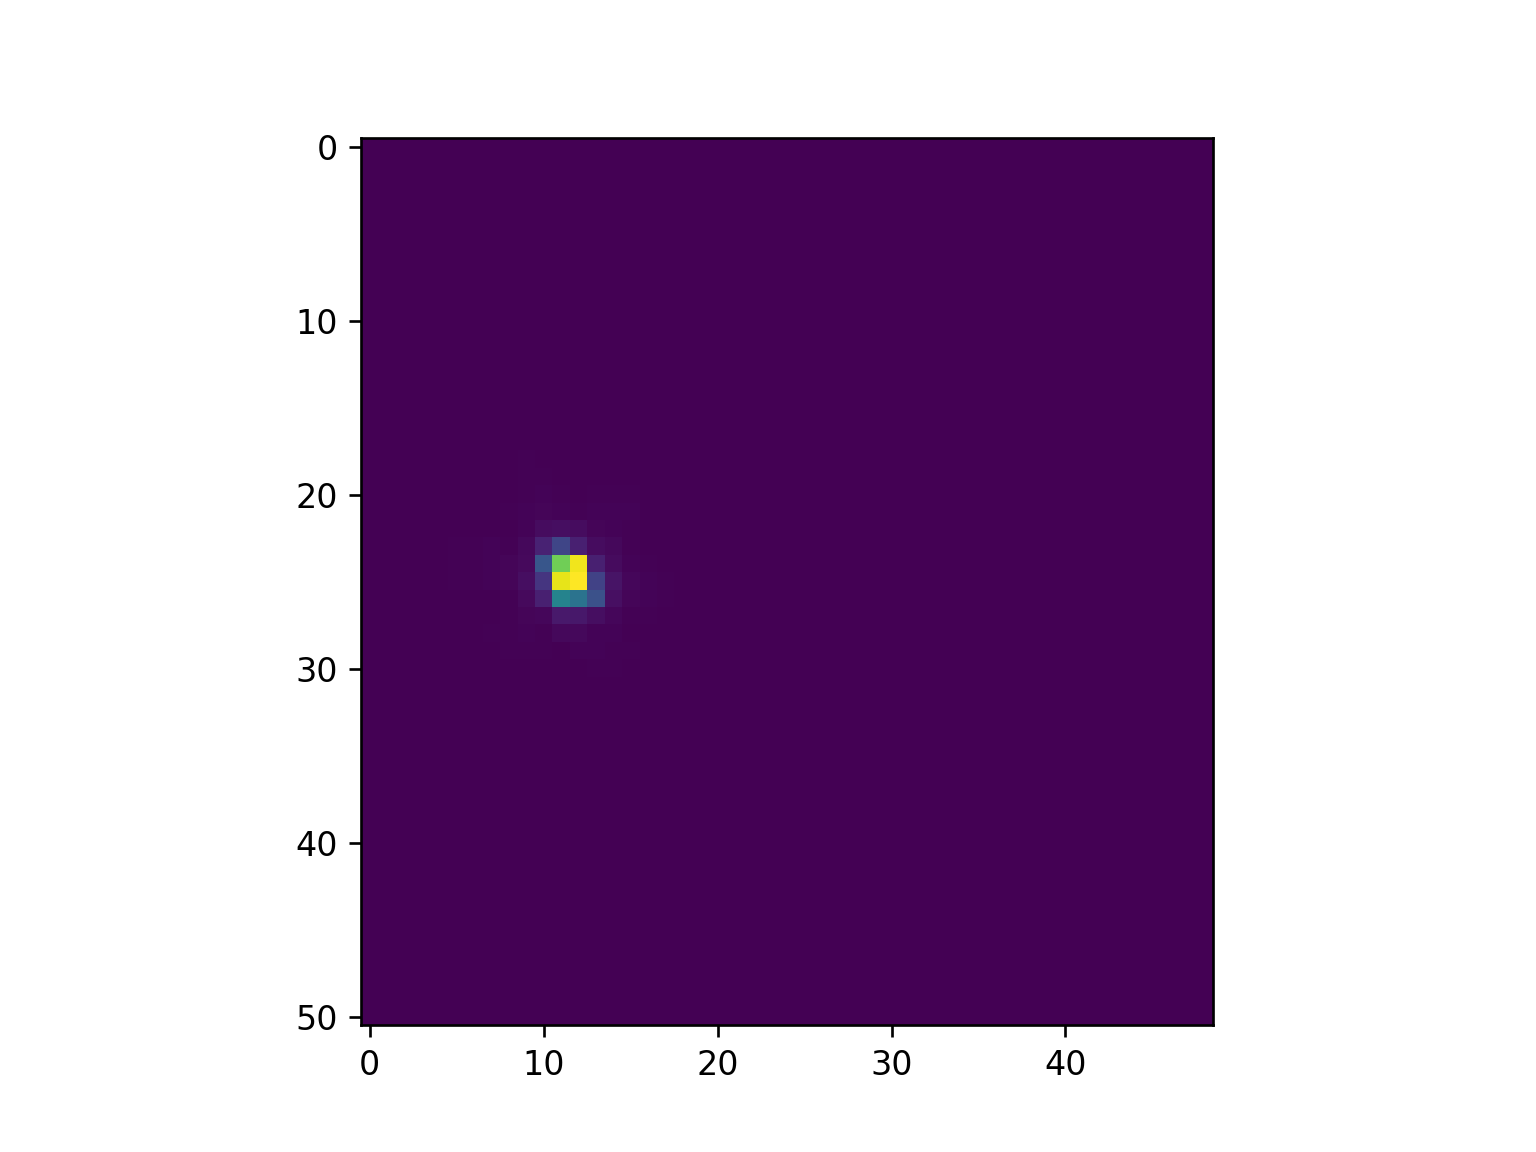

In [6]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.imshow((cube_collapse1/n.nanmax(cube_collapse1)))#, vmin = 0, vmax = 5e-10)
plt.show()

centroids (x, y)
11.518080731956323 24.69061906807404
sigmax, sigma y
1.0000000000000233 1.0067190548156275


<IPython.core.display.Javascript object>


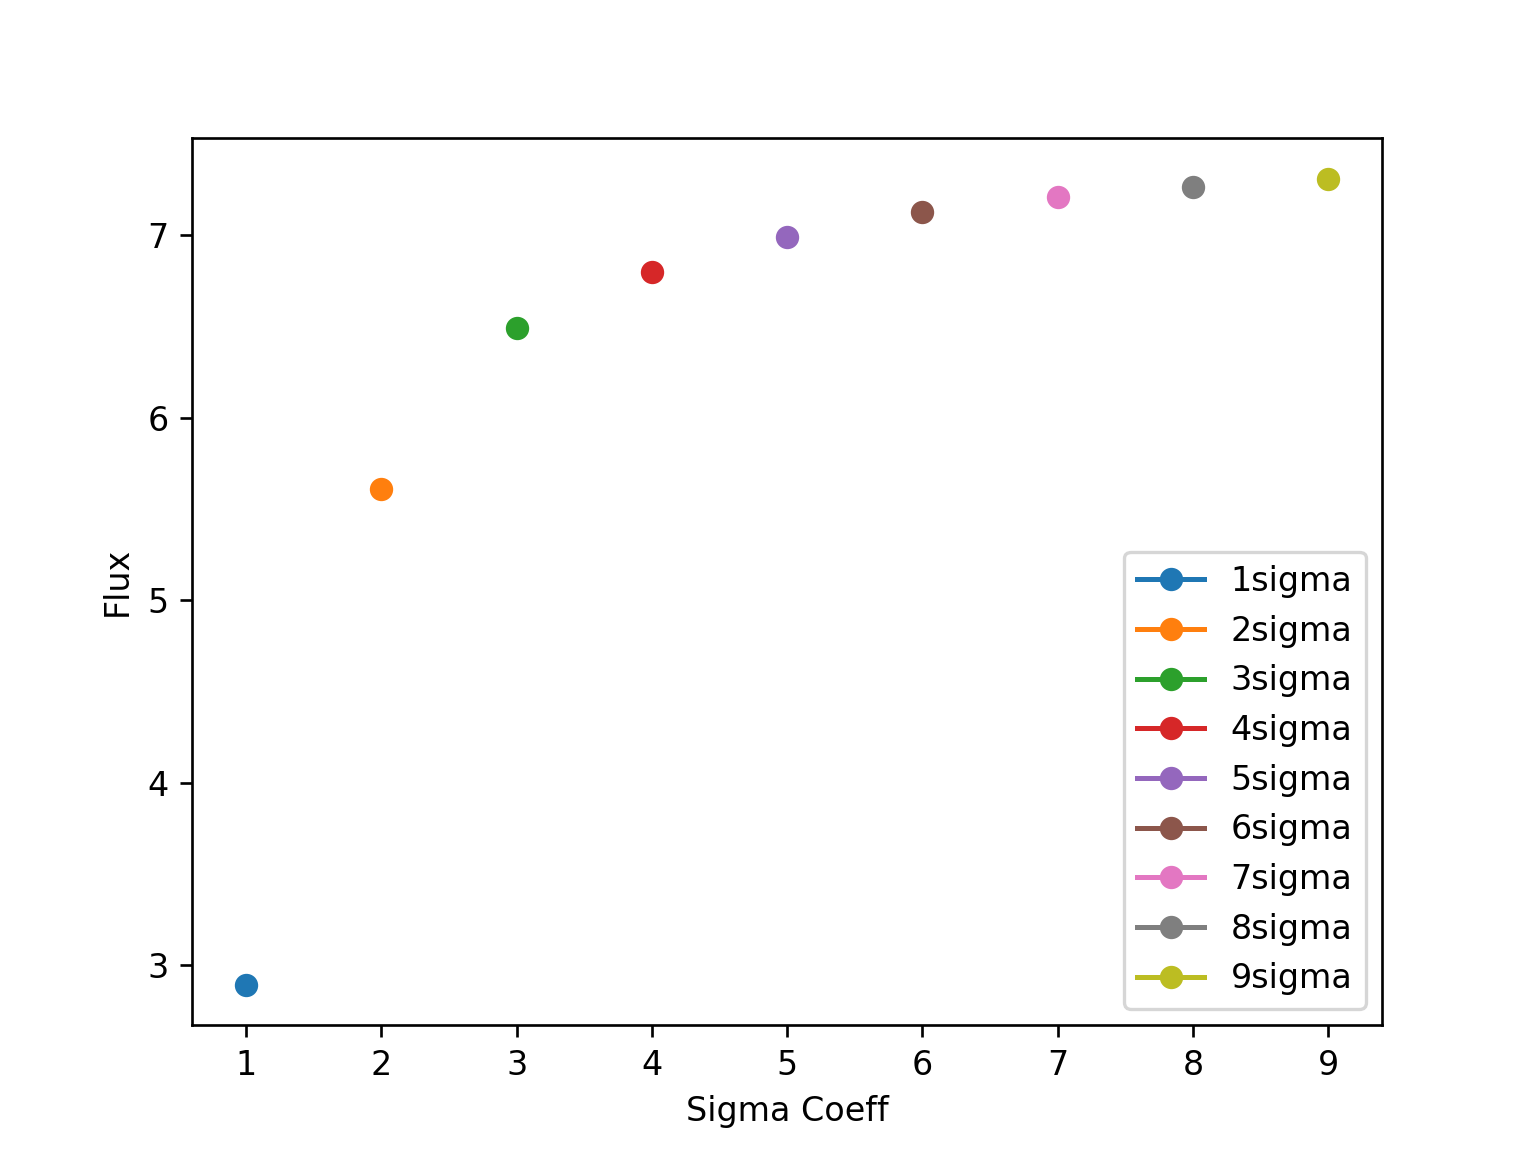

Text(0.5, 0, 'Sigma Coeff')

In [7]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse1/n.nanmax(cube_collapse1)
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([12, 24, n.nanmin(image), 1, 1, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x

print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)

plt.figure('Flux vs Aperture radius')
sigma_coeffs = n.arange(1,10)

for sigma_coeff in sigma_coeffs:

    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coeff, sigma_y_fit * sigma_coeff)  # science image extraction
    phot_table = aperture_photometry(image, aperture)
    flux_val = phot_table['aperture_sum'].data

        
    plt.plot(sigma_coeff, flux_val, marker ='o', label = str(sigma_coeff) + 'sigma')

plt.legend()
plt.show()
#plt.ylim([-1,20])
plt.ylabel('Flux')
plt.xlabel('Sigma Coeff')

In [8]:
sigma_coef_val = 3
n_images, y_dim, x_dim =  cube_data1.shape
flux1 = n.zeros(n_images)
error1 = n.zeros(n_images)
bg = n.zeros(n_images)

for i in n.arange(0,n_images):
    
    image = cube_data1[i]
    image_error = cube_data_err1[i]
    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coef_val, sigma_y_fit * sigma_coef_val)  # science image extraction
    phot_table = aperture_photometry(image, aperture, error = image_error) #error
    #EllipticalAperture(image, aperture, )
    flux_val = phot_table['aperture_sum'].data
    flux_val_err = phot_table['aperture_sum_err'].data
    
    area = aperture.area
    
    flux1[i] = flux_val 
    error1[i] = flux_val_err

<IPython.core.display.Javascript object>


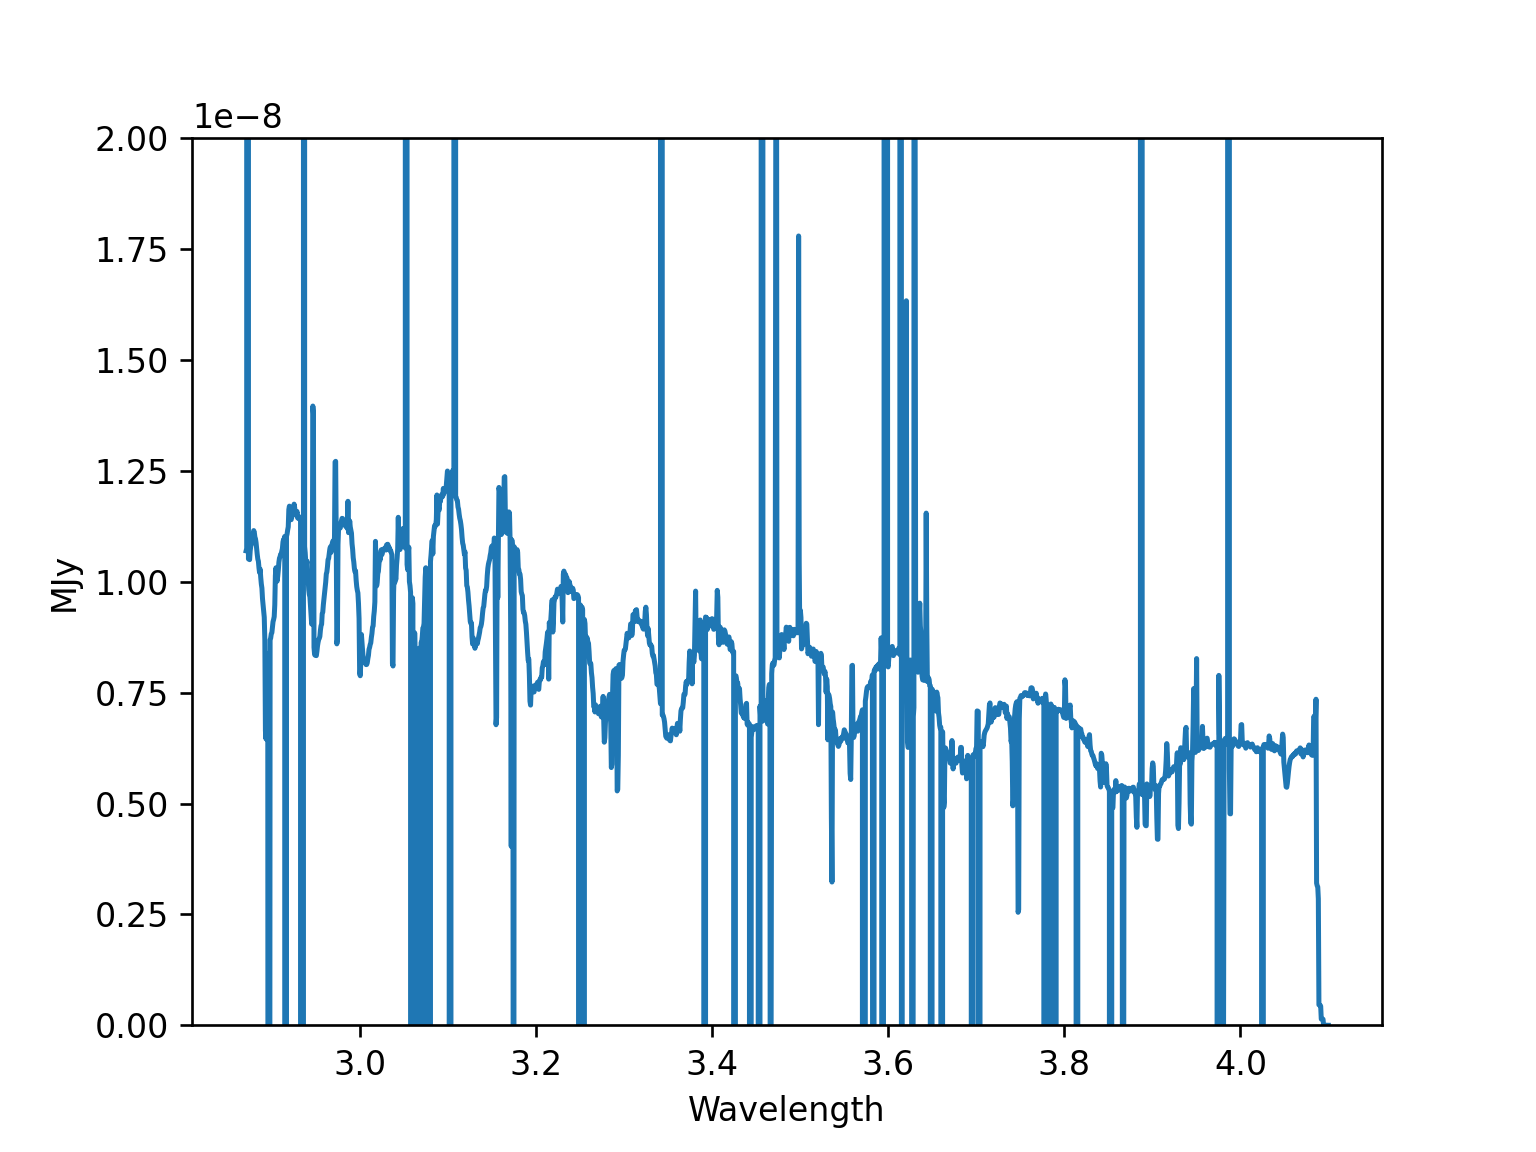

Text(0.5, 0, 'Wavelength')

In [9]:
%matplotlib notebook
plt.figure('spectra')
plt.plot(wavelength1, flux1)
plt.show()
plt.ylim([0,2e-8])
plt.ylabel('MJy')
plt.xlabel('Wavelength')

<IPython.core.display.Javascript object>


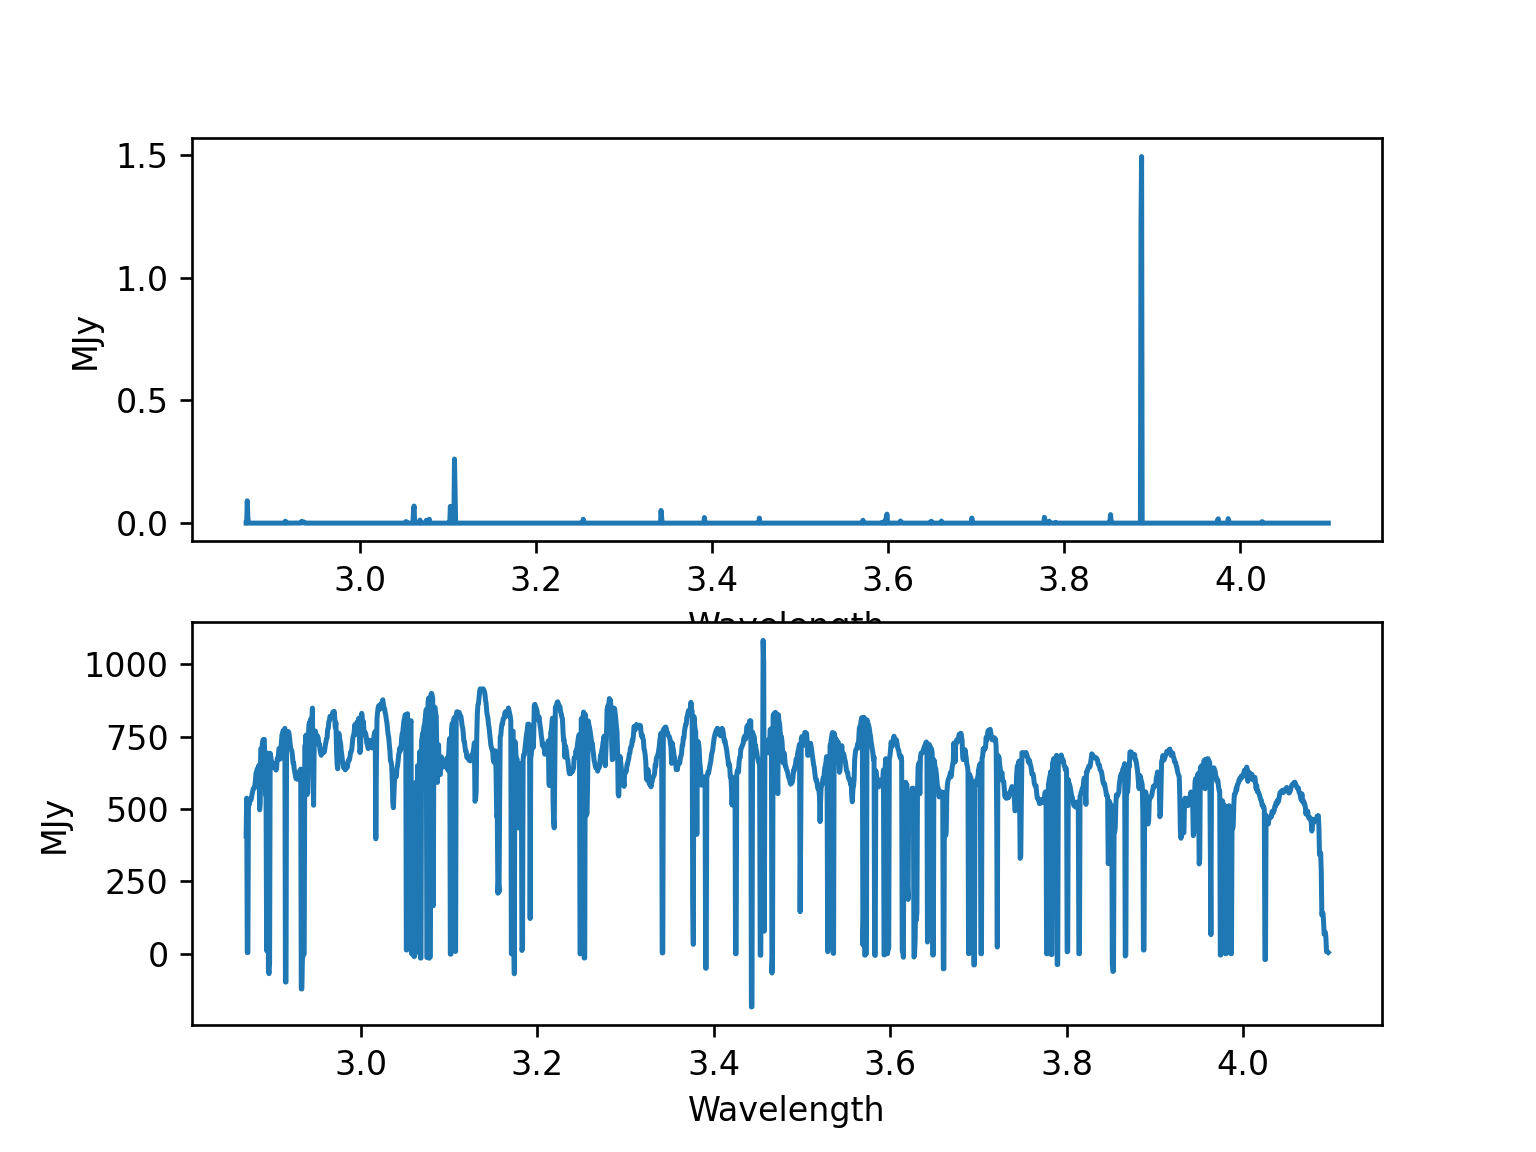

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_47220/1530456687.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(wavelength1, flux1/error1)


Text(0.5, 0, 'Wavelength')

In [10]:
%matplotlib notebook
plt.figure('spectra and snr')
plt.subplot(211)
plt.plot(wavelength1, error1)
plt.show()
#plt.ylim([0,1e-11])
plt.ylabel('MJy')
plt.xlabel('Wavelength')

plt.subplot(212)
plt.plot(wavelength1, flux1/error1)
plt.show()
plt.ylabel('MJy')
plt.xlabel('Wavelength')

# DITHER 2

<IPython.core.display.Javascript object>


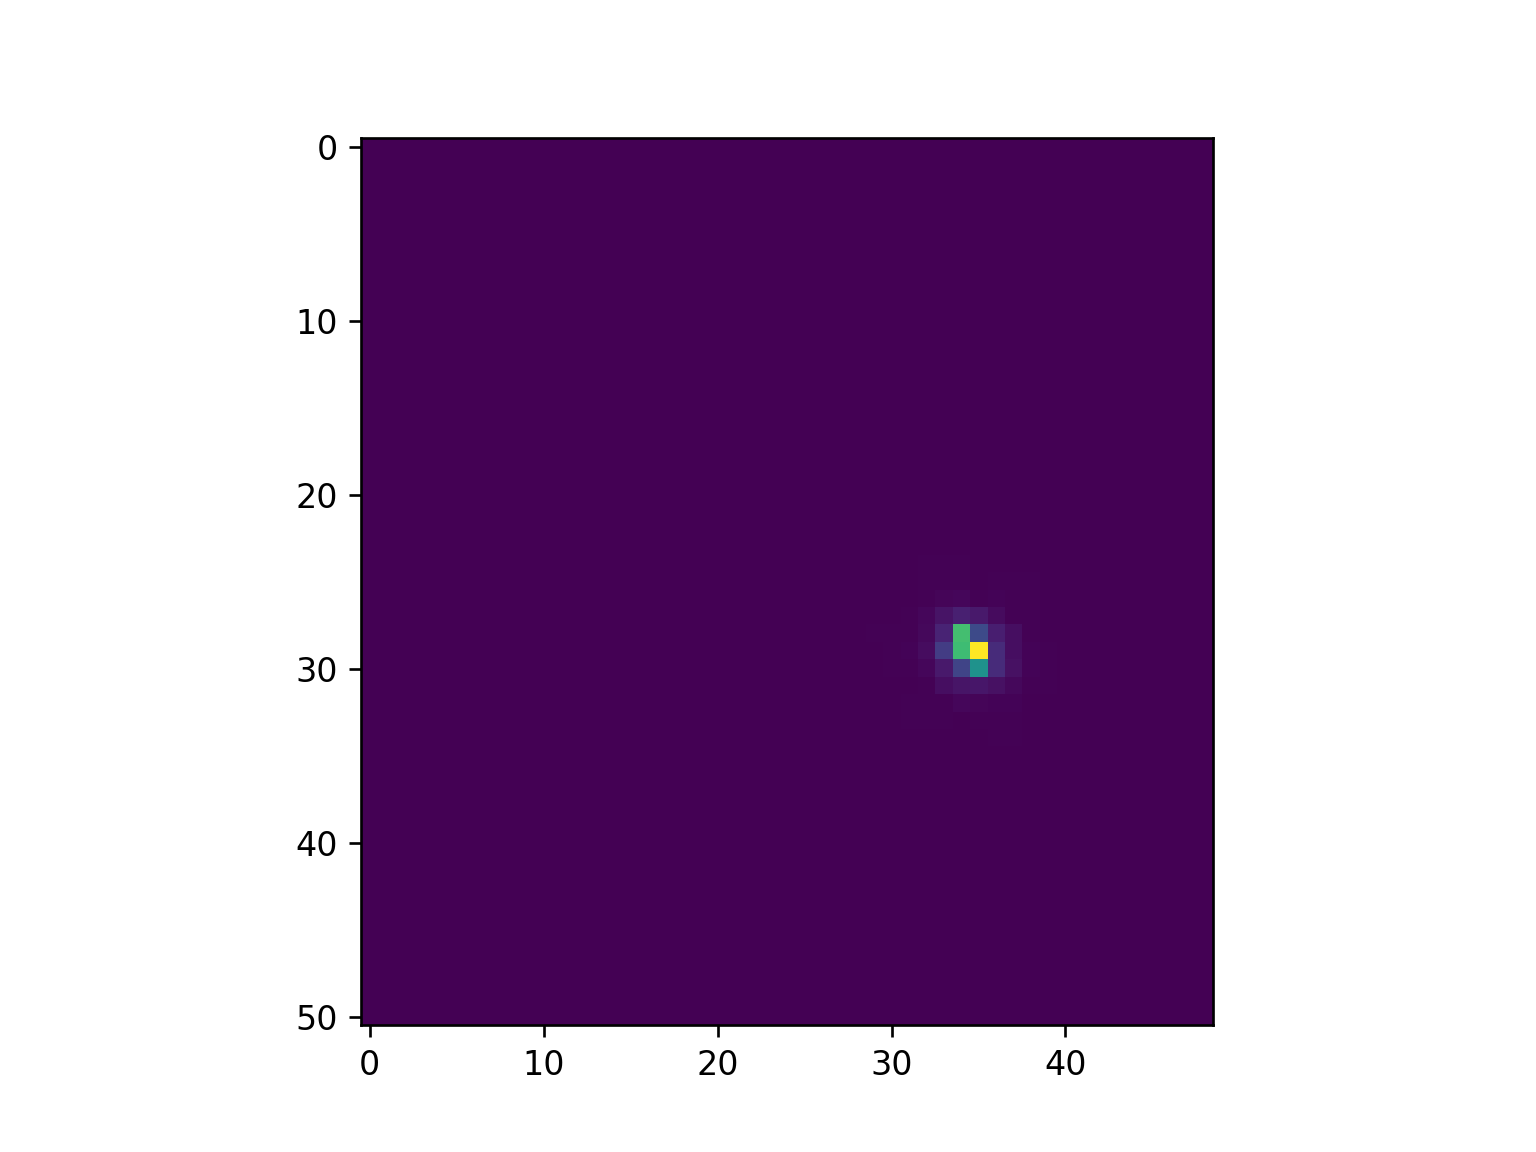

In [11]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.imshow((cube_collapse2/n.nanmax(cube_collapse2)))#, vmin = 0, vmax = 1e-9)
plt.show()

centroids (x, y)
34.538055994117514 28.9264369914821
sigmax, sigma y
1.000000000007275 1.0000000000157658


<IPython.core.display.Javascript object>


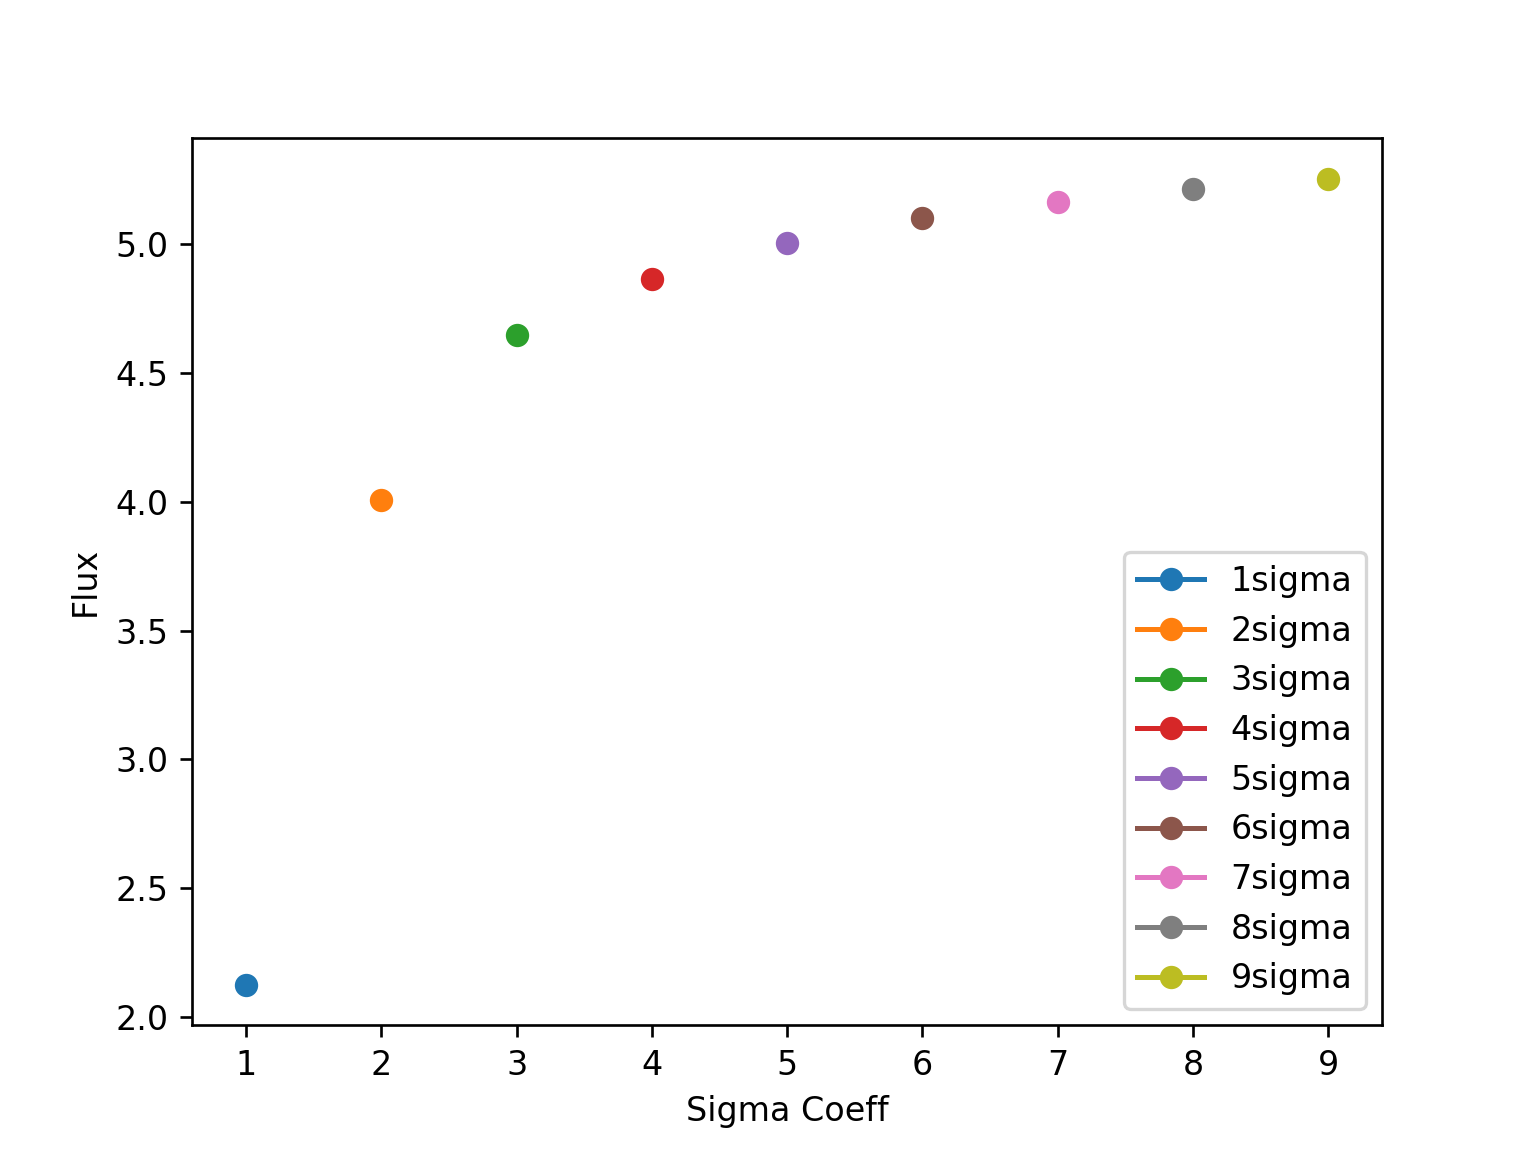

Text(0.5, 0, 'Sigma Coeff')

In [12]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse2/n.nanmax(cube_collapse2)
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([35, 29, n.nanmin(image), 1, 1, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x

print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)

plt.figure('Flux vs Aperture radius')
sigma_coeffs = n.arange(1,10)

for sigma_coeff in sigma_coeffs:

    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coeff, sigma_y_fit * sigma_coeff)  # science image extraction
    phot_table = aperture_photometry(image, aperture)
    flux_val = phot_table['aperture_sum'].data

        
    plt.plot(sigma_coeff, flux_val, marker ='o', label = str(sigma_coeff) + 'sigma')

plt.legend()
plt.show()
#plt.ylim([-1,20])
plt.ylabel('Flux')
plt.xlabel('Sigma Coeff')

In [13]:
sigma_coef_val = 3
n_images, y_dim, x_dim =  cube_data2.shape
flux2 = n.zeros(n_images)
error2 = n.zeros(n_images)
bg = n.zeros(n_images)

for i in n.arange(0,n_images):
    
    image = cube_data2[i]
    image_error = cube_data_err2[i]
    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coef_val, sigma_y_fit * sigma_coef_val)  # science image extraction
    phot_table = aperture_photometry(image, aperture, error = image_error) #error
    flux_val = phot_table['aperture_sum'].data
    flux_val_err = phot_table['aperture_sum_err'].data
    
    area = aperture.area
    
    flux2[i] = flux_val 
    error2[i] = flux_val_err

<IPython.core.display.Javascript object>


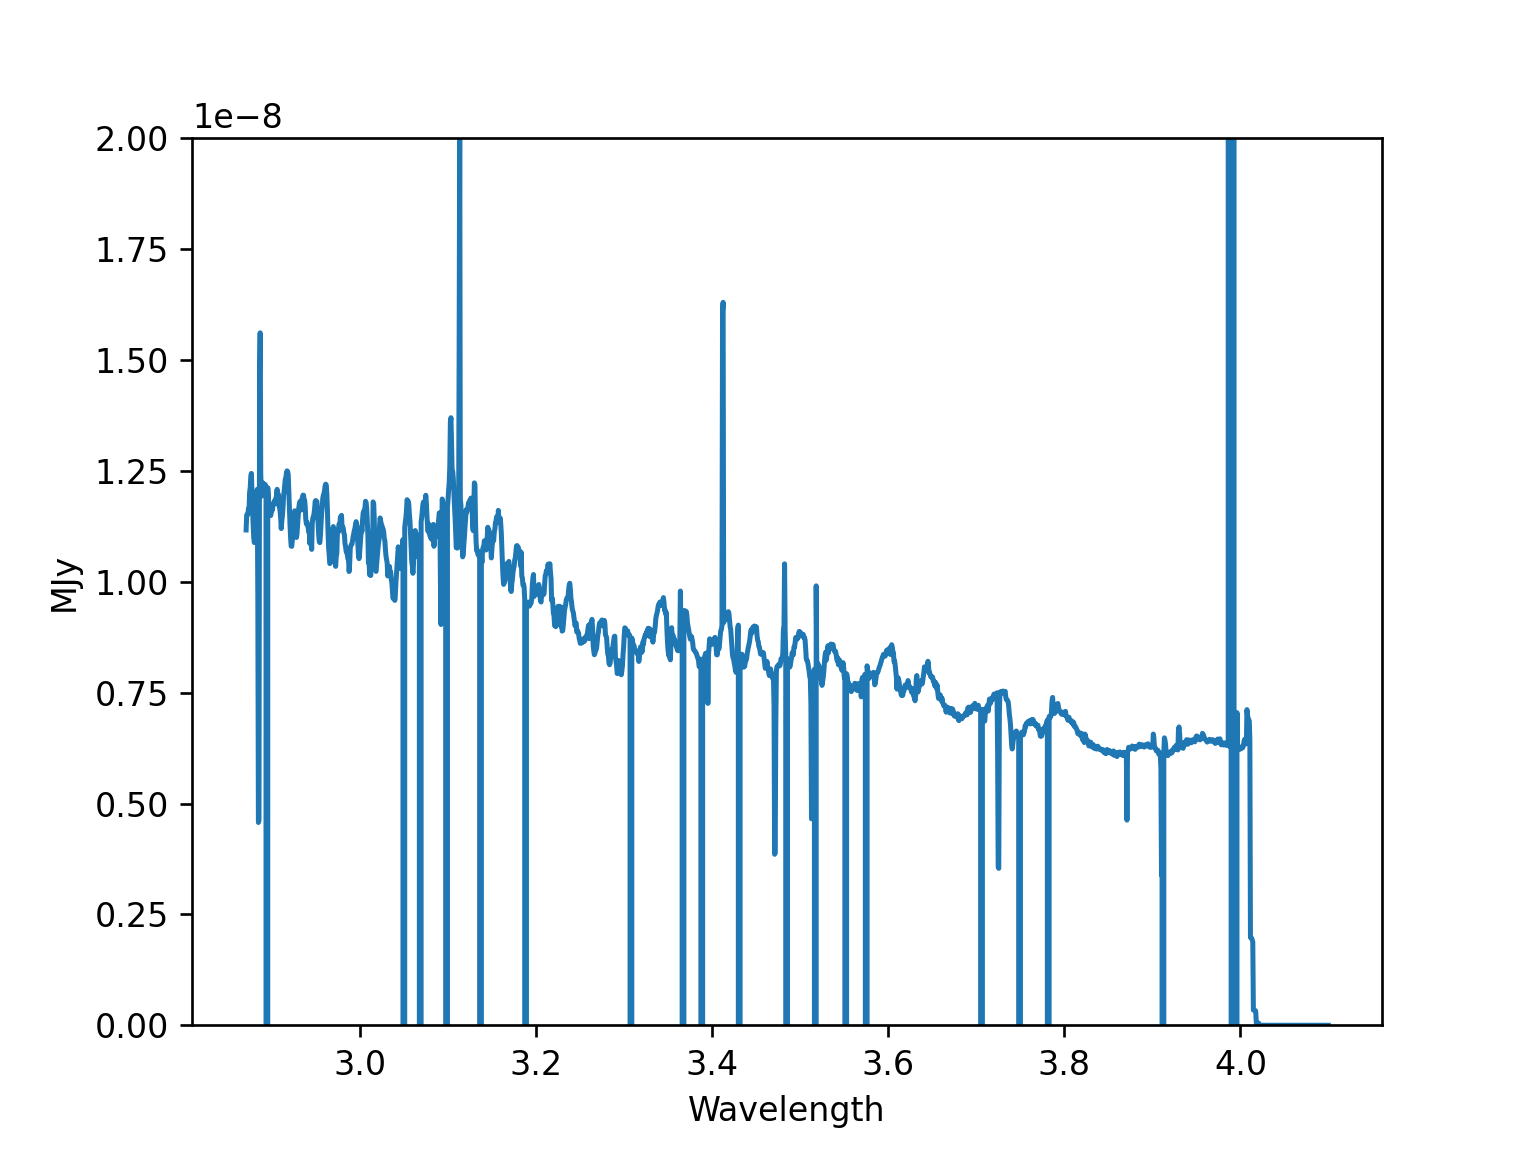

Text(0.5, 0, 'Wavelength')

In [14]:
%matplotlib notebook
plt.figure('spectra')
plt.plot(wavelength2, flux2)
plt.show()
plt.ylim([0,2e-8])
plt.ylabel('MJy')
plt.xlabel('Wavelength')

<IPython.core.display.Javascript object>


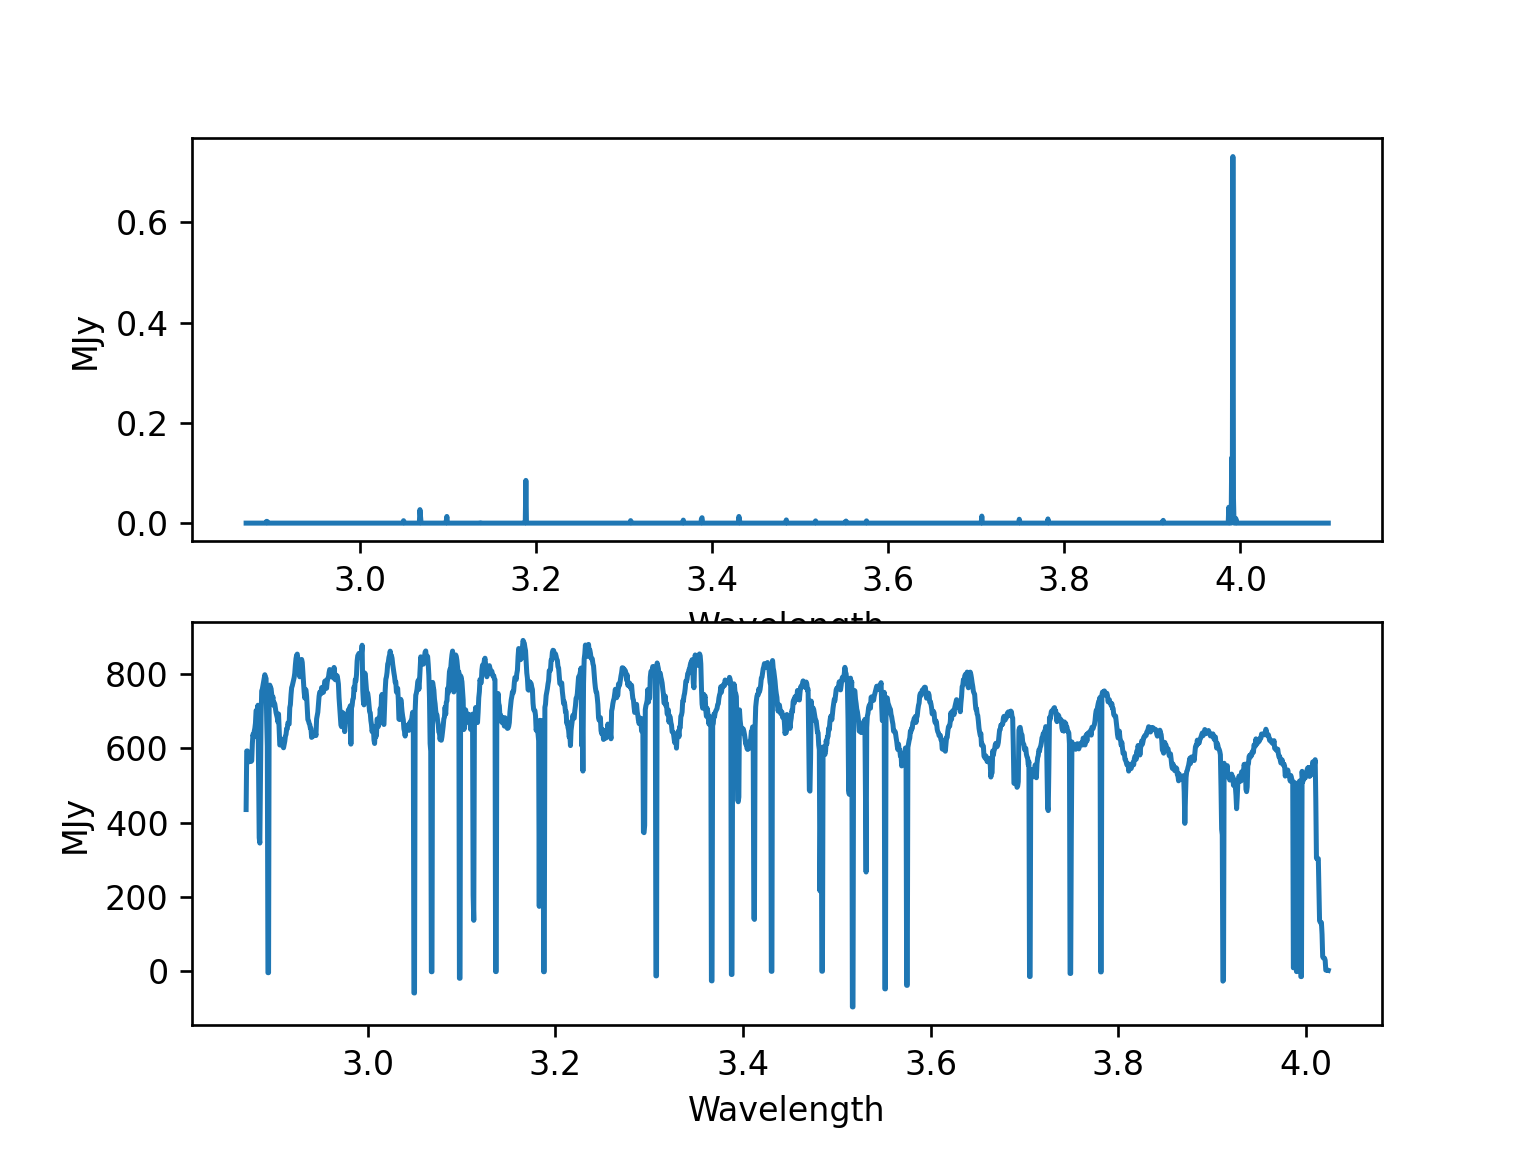

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_47220/3295678400.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(wavelength2, flux2/error2)


Text(0.5, 0, 'Wavelength')

In [15]:
%matplotlib notebook
plt.figure('spectra and snr')
plt.subplot(211)
plt.plot(wavelength2, error2)
plt.show()
plt.ylabel('MJy')
plt.xlabel('Wavelength')

plt.subplot(212)
plt.plot(wavelength2, flux2/error2)
plt.show()
plt.ylabel('MJy')
plt.xlabel('Wavelength')

# DITHER 3

<IPython.core.display.Javascript object>


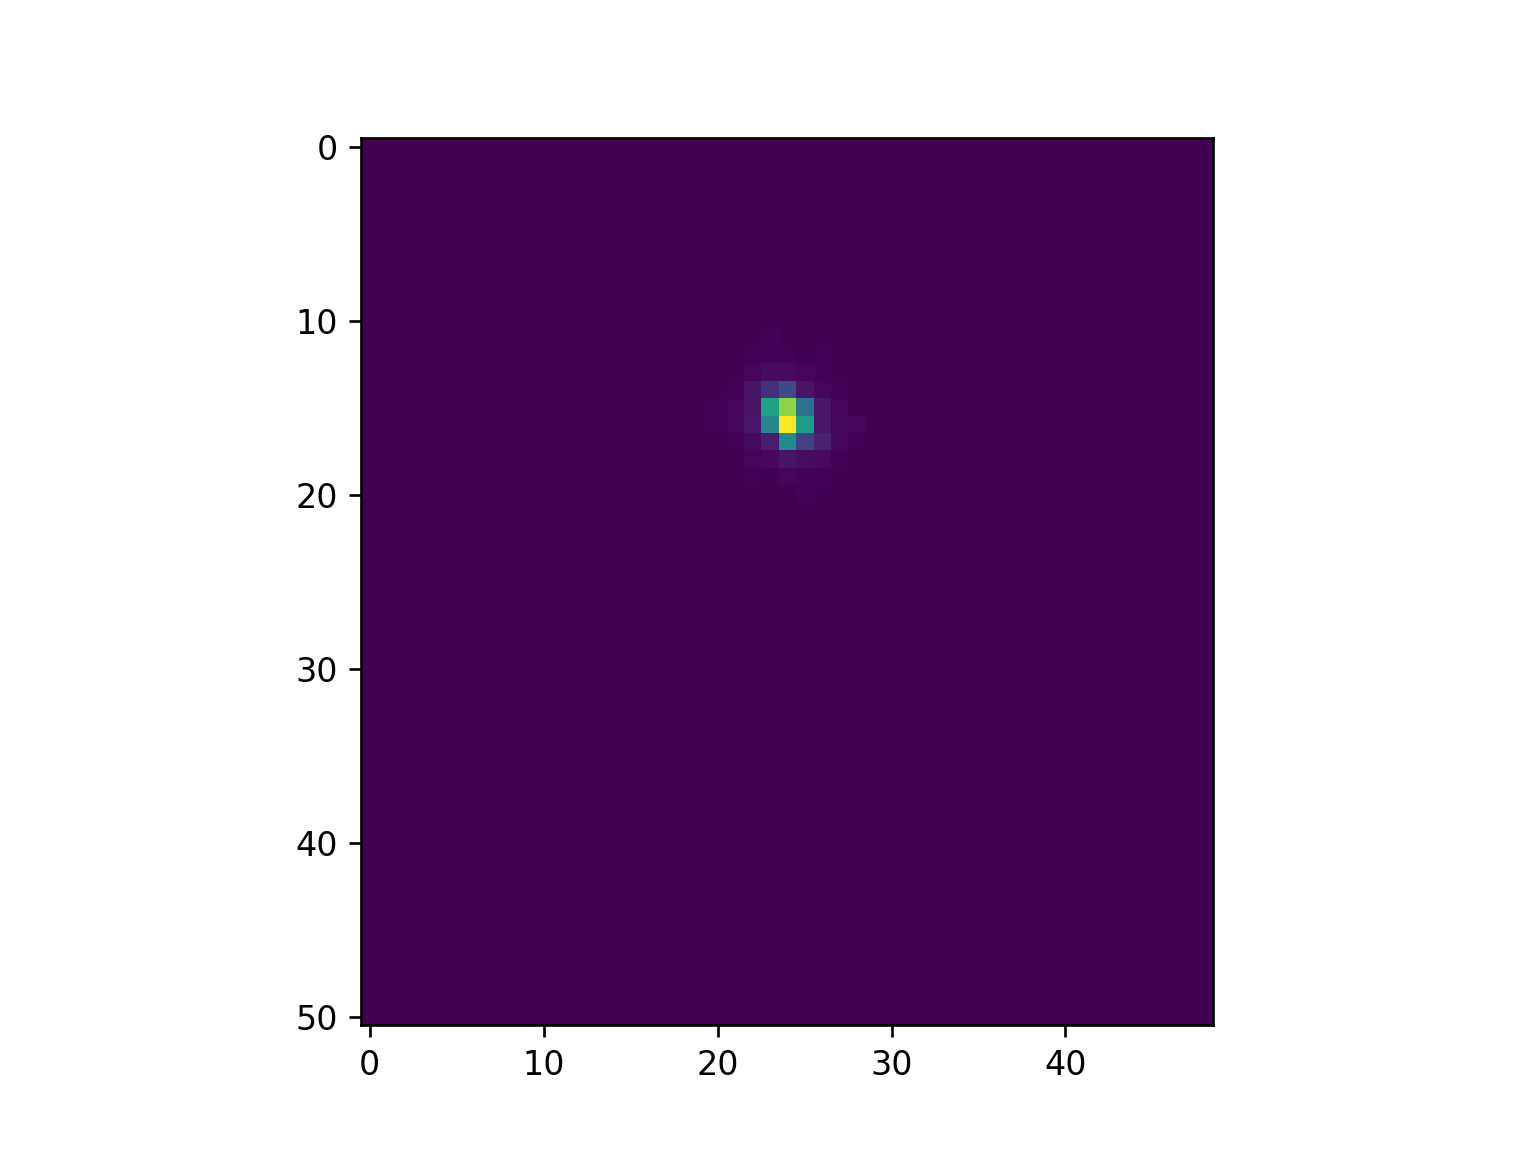

In [16]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.imshow((cube_collapse3/n.nanmax(cube_collapse3)))
plt.show()

centroids (x, y)
23.988885509896882 15.649701577885288
sigmax, sigma y
1.0000000000189297 1.0000000000564717


<IPython.core.display.Javascript object>


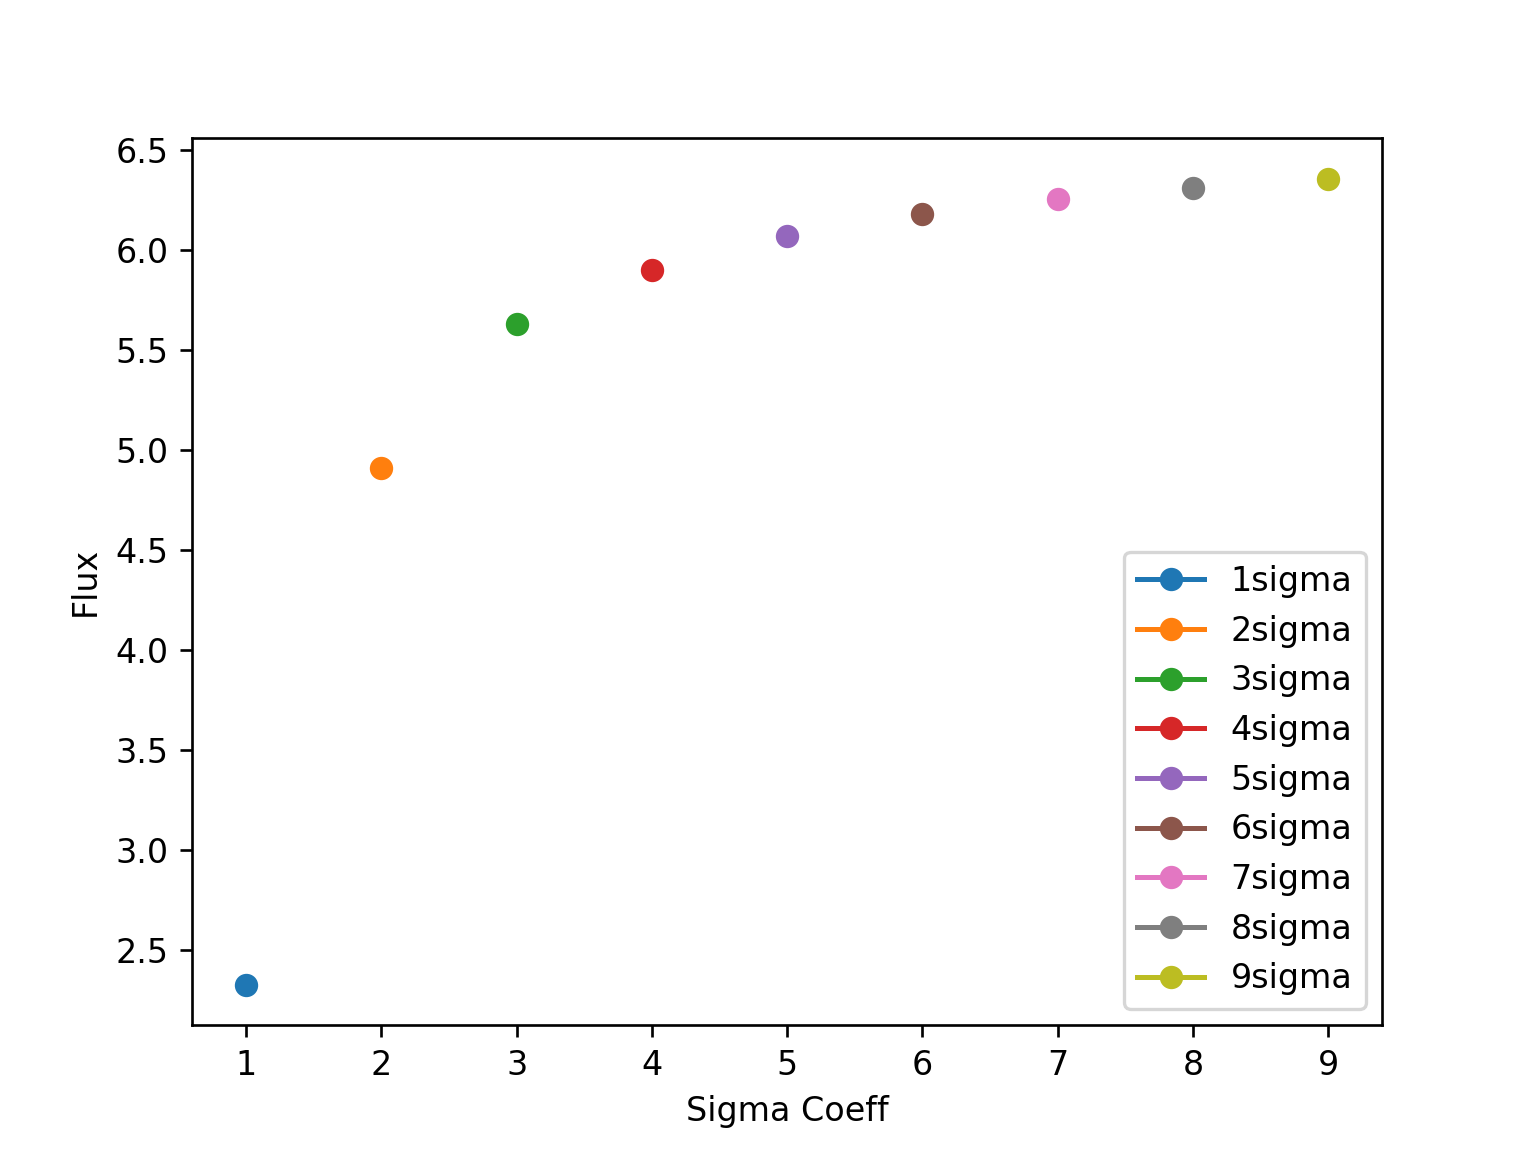

Text(0.5, 0, 'Sigma Coeff')

In [17]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse3/n.nanmax(cube_collapse3)
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([24., 16., n.nanmin(image), 1, 1, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x

print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)


plt.figure('Flux vs Aperture radius')
sigma_coeffs = n.arange(1,10)

for sigma_coeff in sigma_coeffs:

    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coeff, sigma_y_fit * sigma_coeff)  # science image extraction
    phot_table = aperture_photometry(image, aperture)
    flux_val = phot_table['aperture_sum'].data

        
    plt.plot(sigma_coeff, flux_val, marker ='o', label = str(sigma_coeff) + 'sigma')

plt.legend()
plt.show()
#plt.ylim([-1,20])
plt.ylabel('Flux')
plt.xlabel('Sigma Coeff')

In [18]:
sigma_coef_val = 3
n_images, y_dim, x_dim =  cube_data3.shape
flux3 = n.zeros(n_images)
error3 = n.zeros(n_images)
bg = n.zeros(n_images)

for i in n.arange(0,n_images):
    
    image = cube_data3[i]
    image_error = cube_data_err3[i]
    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coef_val, sigma_y_fit * sigma_coef_val)  # science image extraction
    phot_table = aperture_photometry(image, aperture, error = image_error) #error
    flux_val = phot_table['aperture_sum'].data
    flux_val_err = phot_table['aperture_sum_err'].data
    
    area = aperture.area
    
    flux3[i] = flux_val 
    error3[i] = flux_val_err

<IPython.core.display.Javascript object>


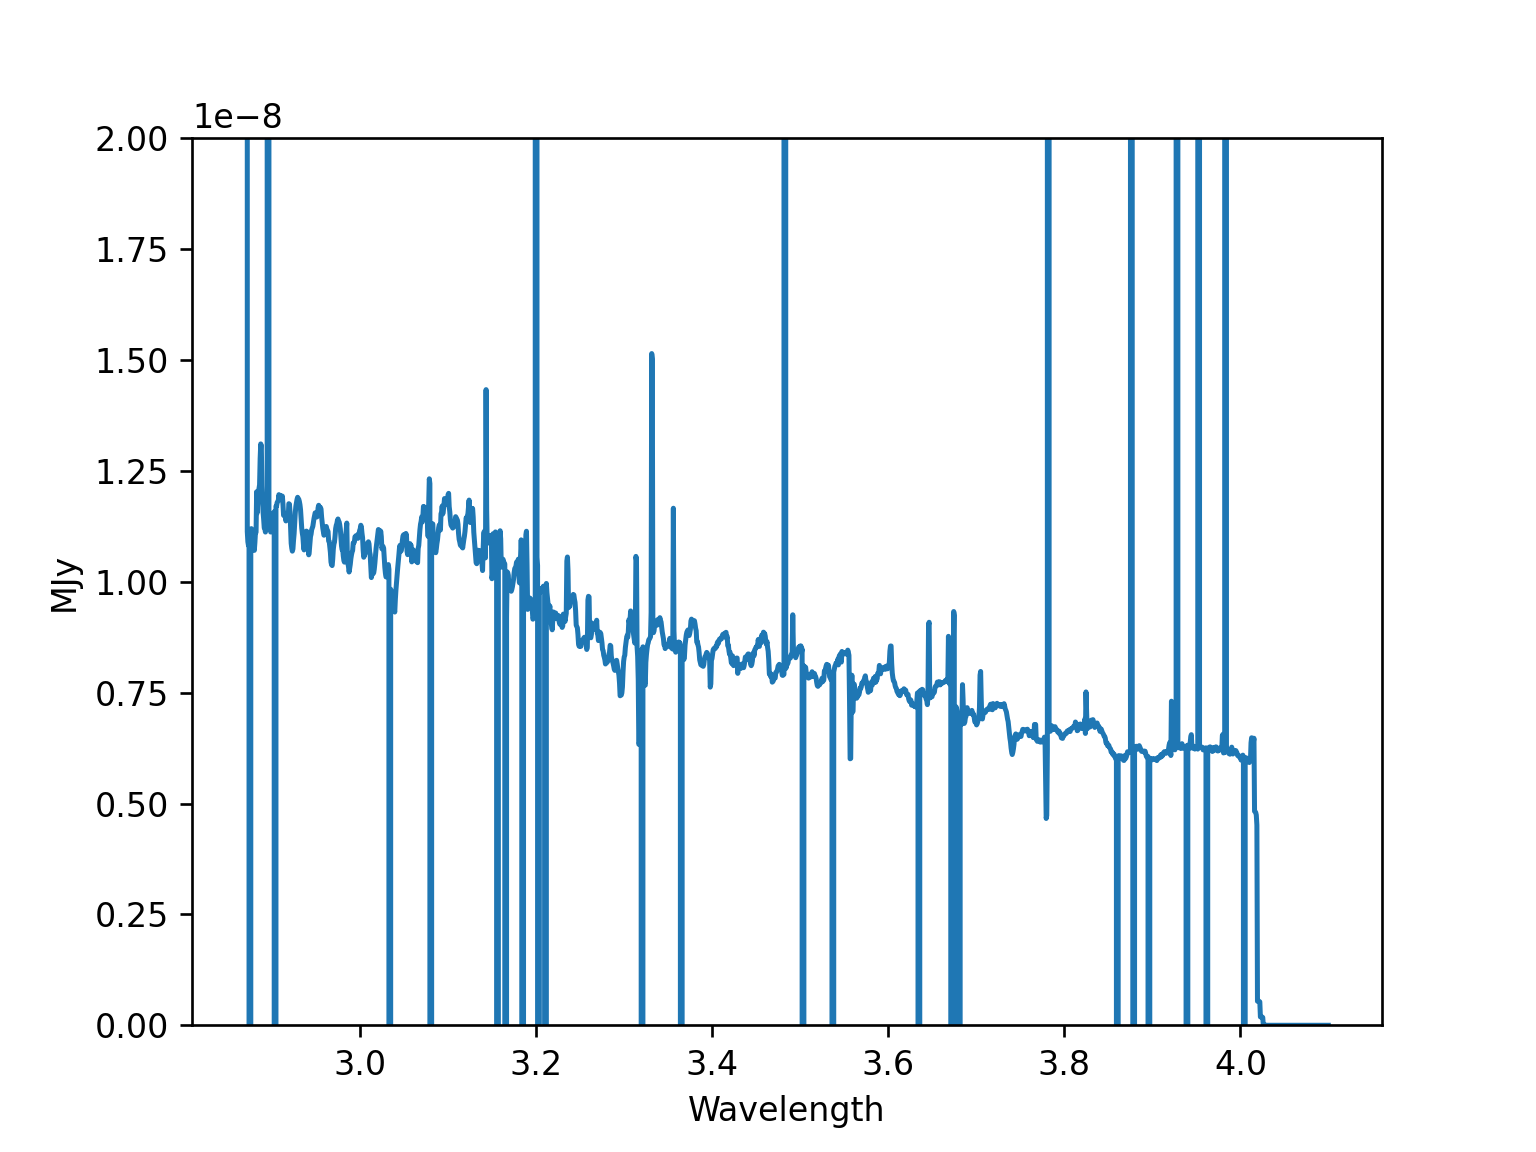

Text(0.5, 0, 'Wavelength')

In [19]:
%matplotlib notebook
plt.figure('spectra')
plt.plot(wavelength3, flux3)
plt.show()
plt.ylim([0,2e-8])
plt.ylabel('MJy')
plt.xlabel('Wavelength')

<IPython.core.display.Javascript object>


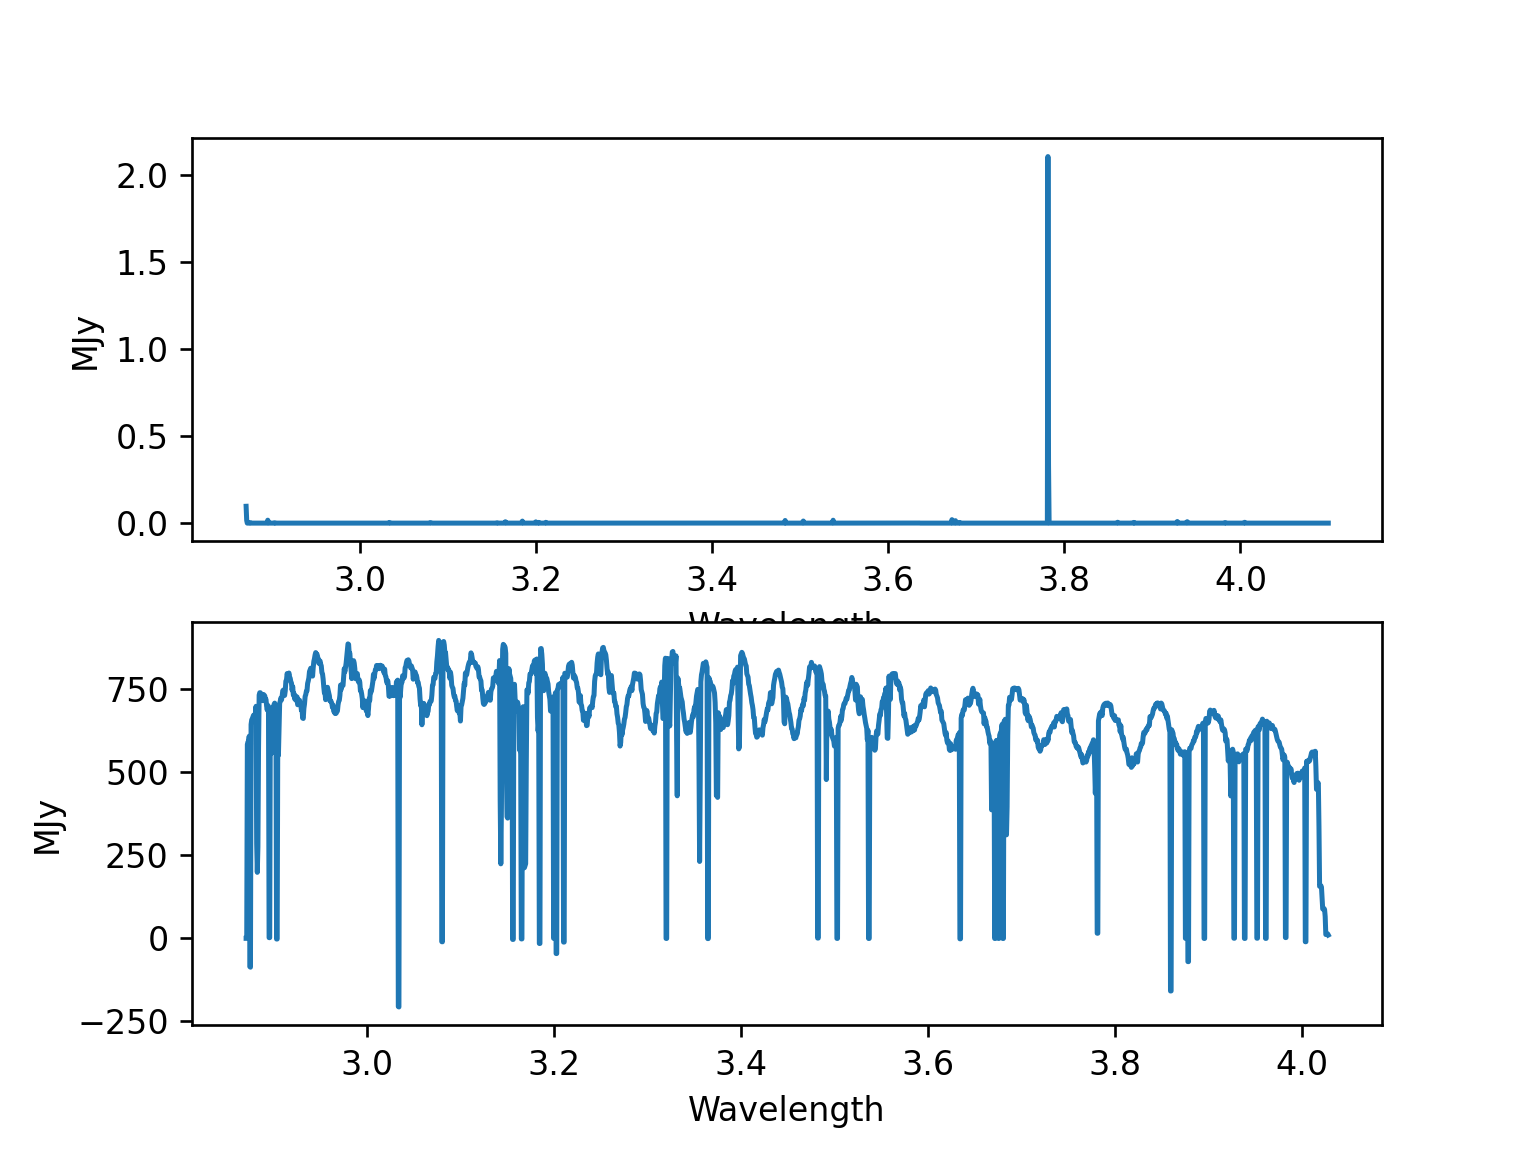

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_47220/3757579632.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(wavelength3, flux3/error3)


Text(0.5, 0, 'Wavelength')

In [20]:
%matplotlib notebook
plt.figure('spectra and snr')
plt.subplot(211)
plt.plot(wavelength3, error3)
plt.show()
plt.ylabel('MJy')
plt.xlabel('Wavelength')

plt.subplot(212)
plt.plot(wavelength3, flux3/error3)
plt.show()
plt.ylabel('MJy')
plt.xlabel('Wavelength')

# DITHER 4

<IPython.core.display.Javascript object>


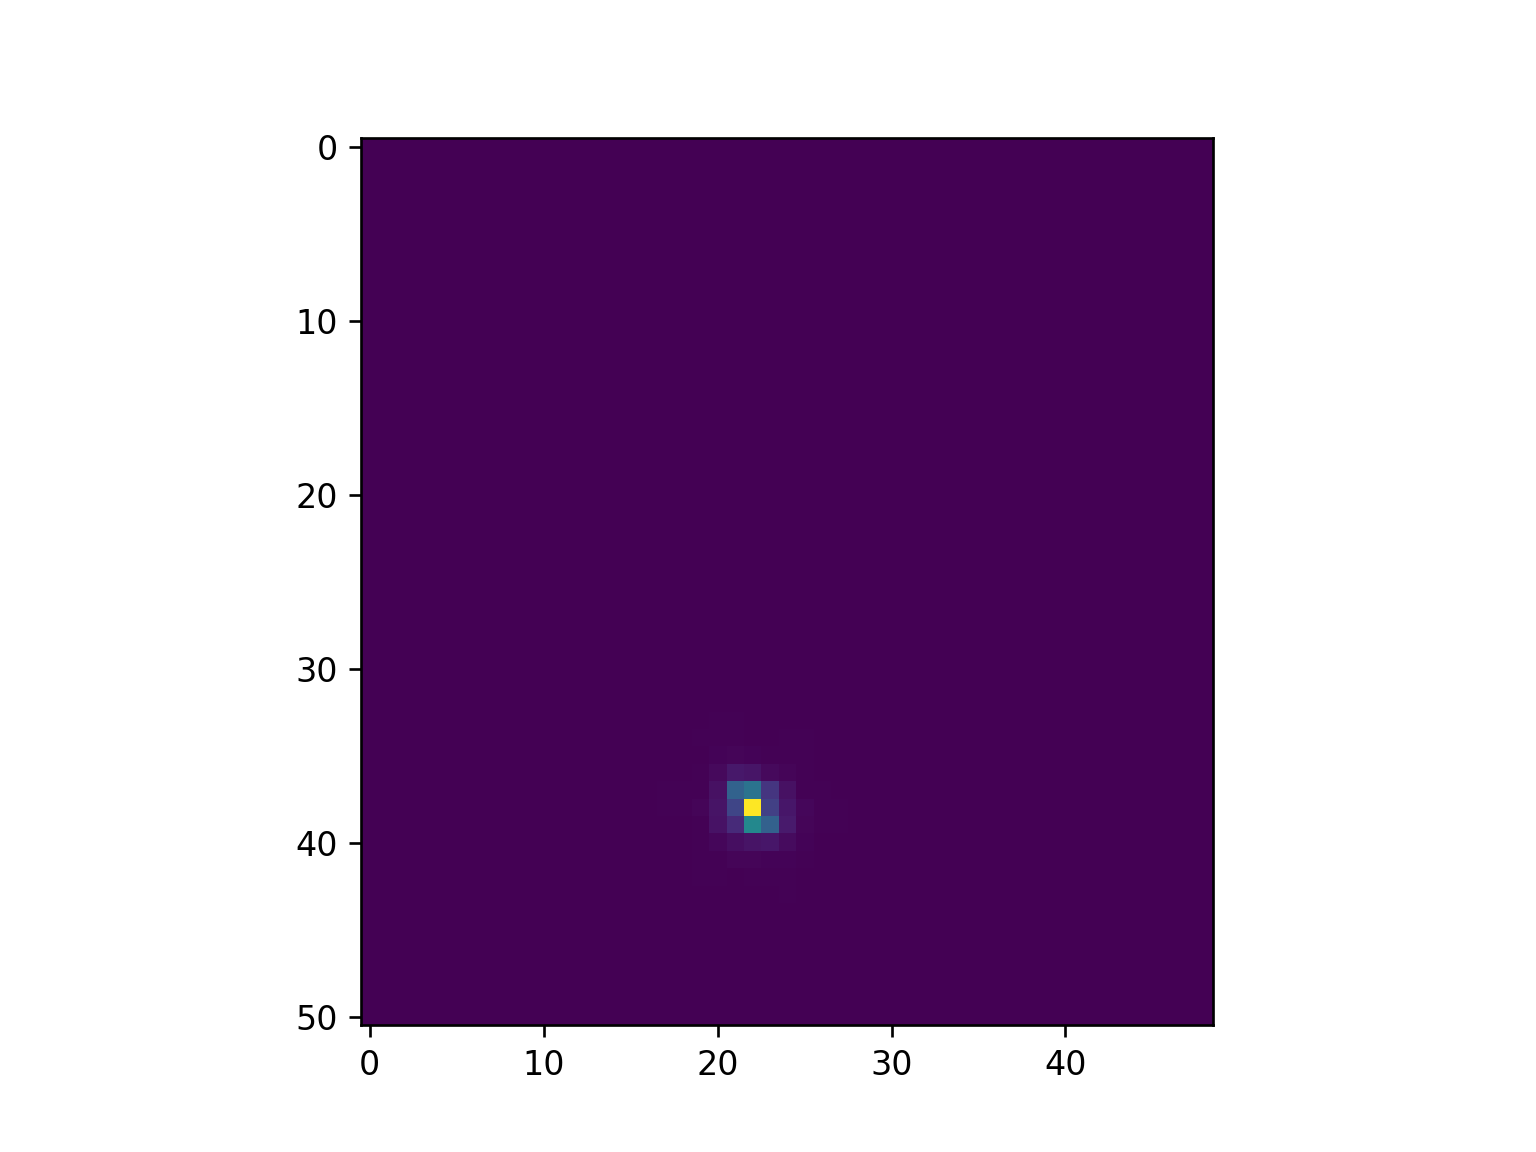

In [21]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.imshow((cube_collapse4/n.nanmax(cube_collapse4)))
plt.show()

centroids (x, y)
22.005549390744896 38.03470747060916
sigmax, sigma y
1.0000000000027358 1.0000000000374405


<IPython.core.display.Javascript object>


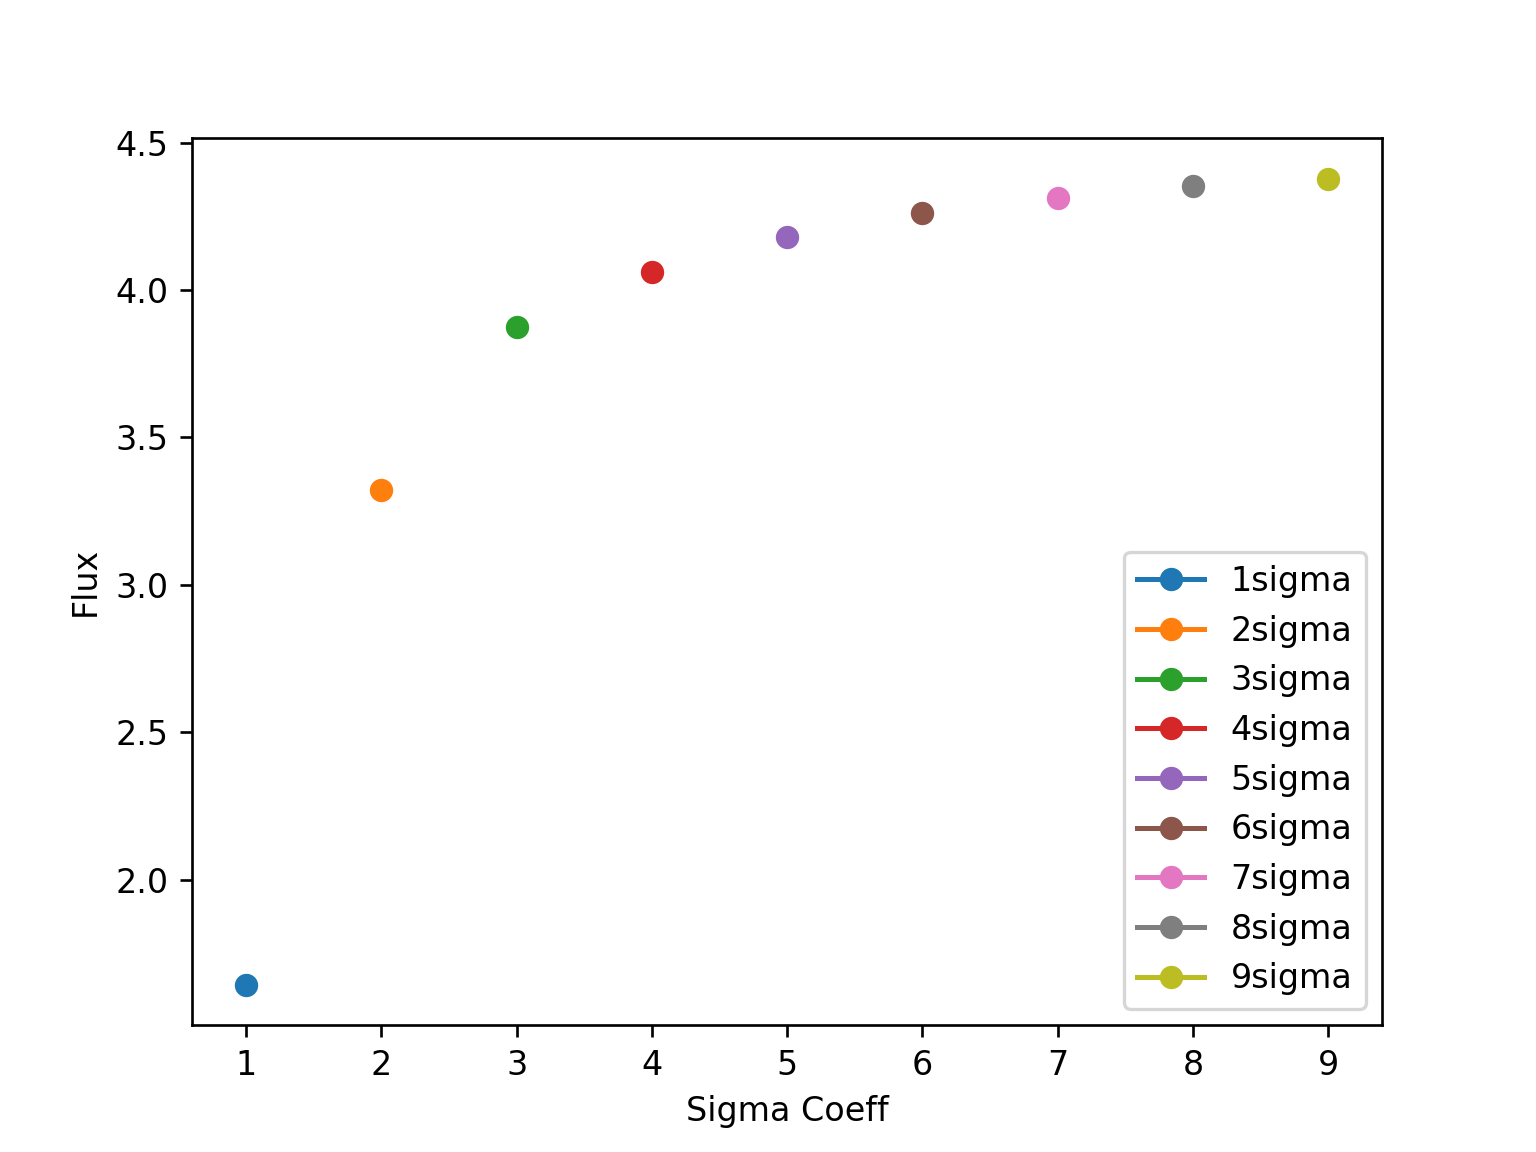

Text(0.5, 0, 'Sigma Coeff')

In [22]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse4/n.nanmax(cube_collapse4)
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([22, 38, n.nanmin(image), 1, 1, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x

print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)

plt.figure('Flux vs Aperture radius')
sigma_coeffs = n.arange(1,10)

for sigma_coeff in sigma_coeffs:

    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coeff, sigma_y_fit * sigma_coeff)  # science image extraction
    phot_table = aperture_photometry(image, aperture)
    flux_val = phot_table['aperture_sum'].data

        
    plt.plot(sigma_coeff, flux_val, marker ='o', label = str(sigma_coeff) + 'sigma')

plt.legend()
plt.show()
#plt.ylim([-1,20])
plt.ylabel('Flux')
plt.xlabel('Sigma Coeff')

In [23]:
sigma_coef_val = 3
n_images, y_dim, x_dim =  cube_data4.shape
flux4 = n.zeros(n_images)
error4 = n.zeros(n_images)
bg = n.zeros(n_images)

for i in n.arange(0,n_images):
    
    image = cube_data4[i]
    image_error = cube_data_err4[i]
    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coef_val, sigma_y_fit * sigma_coef_val)  # science image extraction
    phot_table = aperture_photometry(image, aperture, error = image_error) #error
    flux_val = phot_table['aperture_sum'].data
    flux_val_err = phot_table['aperture_sum_err'].data
    
    area = aperture.area
    
    flux4[i] = flux_val 
    error4[i] = flux_val_err

<IPython.core.display.Javascript object>


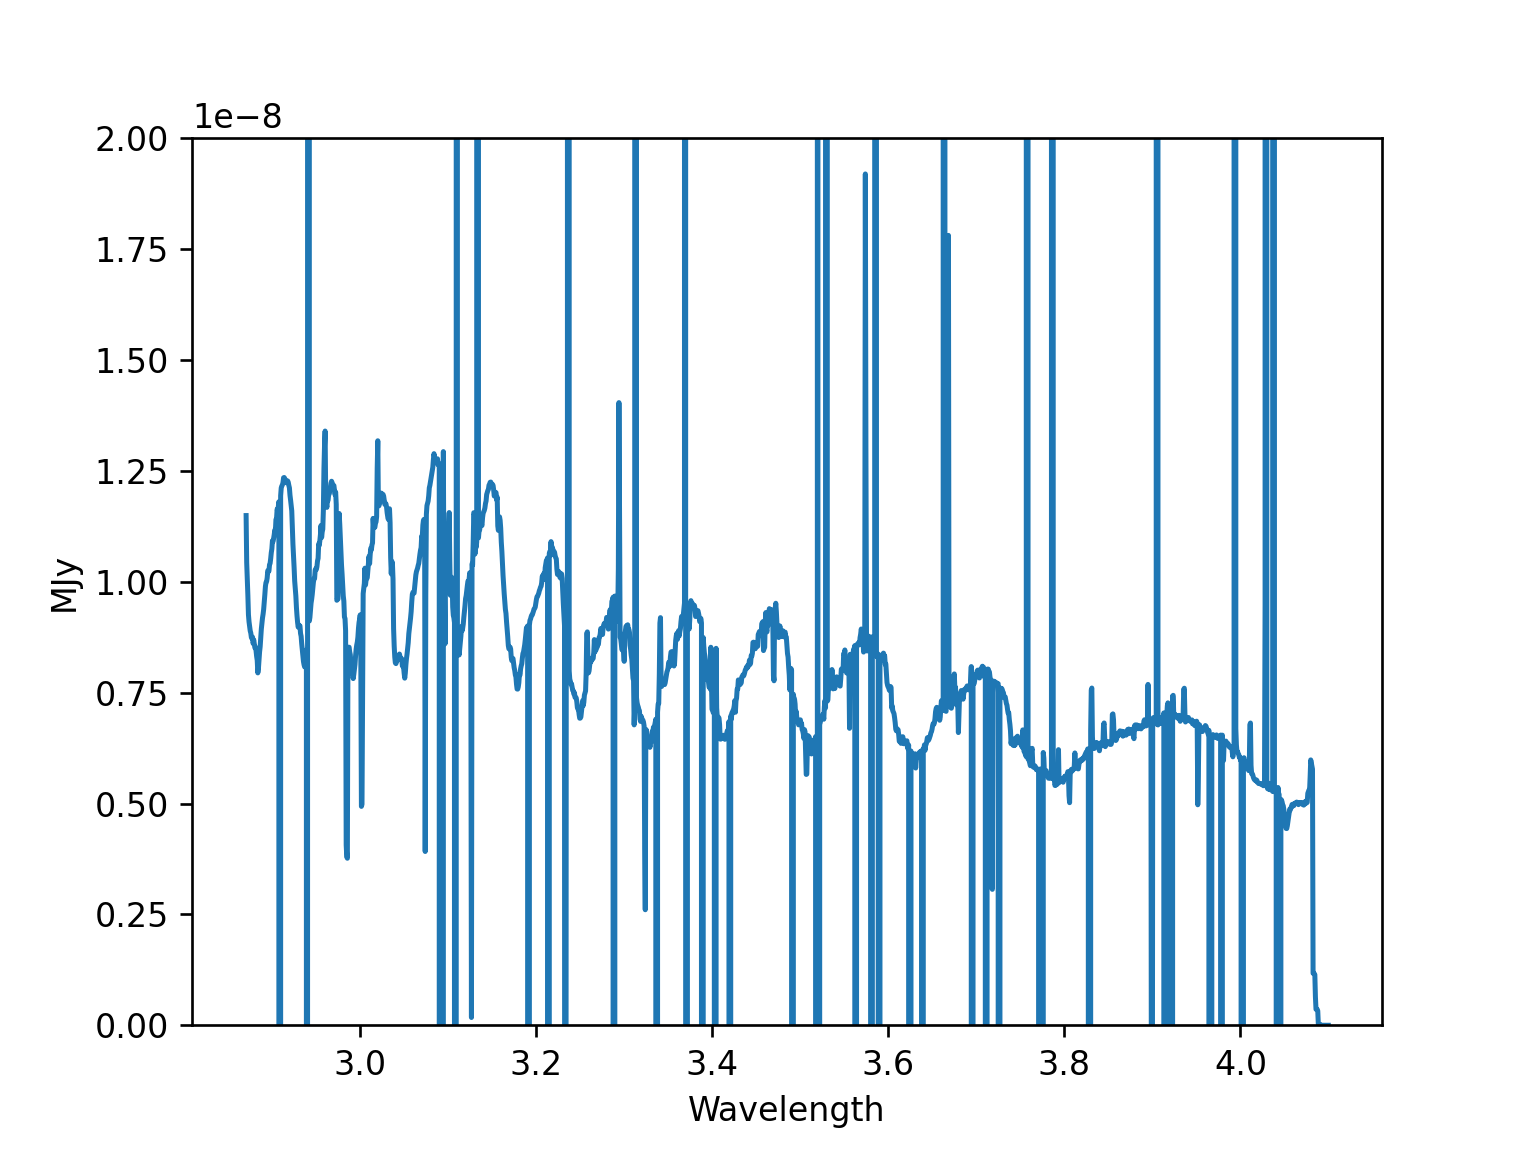

Text(0.5, 0, 'Wavelength')

In [24]:
%matplotlib notebook
plt.figure('spectra')
plt.plot(wavelength4, flux4)
plt.show()
plt.ylim([0,2e-8])
plt.ylabel('MJy')
plt.xlabel('Wavelength')

<IPython.core.display.Javascript object>


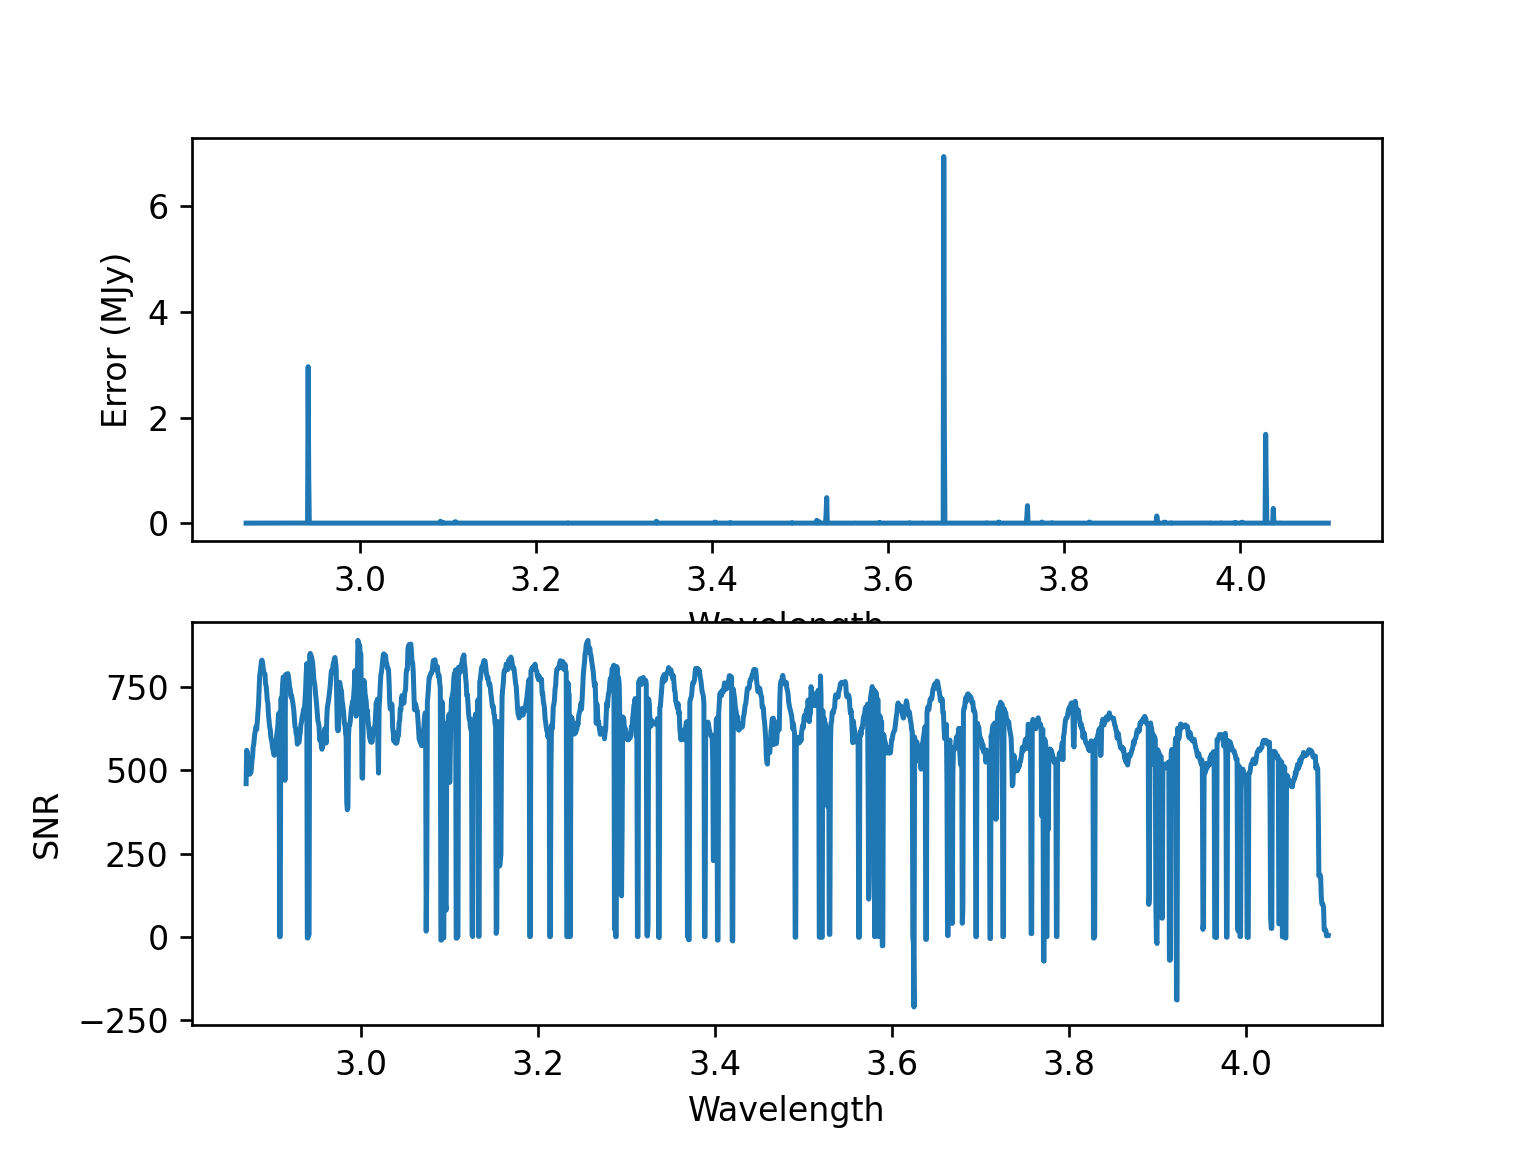

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_47220/2928551135.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(wavelength4, flux4/error4)


Text(0.5, 0, 'Wavelength')

In [25]:
%matplotlib notebook
plt.figure('spectra and snr')
plt.subplot(211)
plt.plot(wavelength4, error4)
plt.show()
#plt.ylim([0,1e-11])
plt.ylabel('Error (MJy)')
plt.xlabel('Wavelength')

plt.subplot(212)
plt.plot(wavelength4, flux4/error4)
plt.show()
plt.ylabel('SNR')
plt.xlabel('Wavelength')

<IPython.core.display.Javascript object>


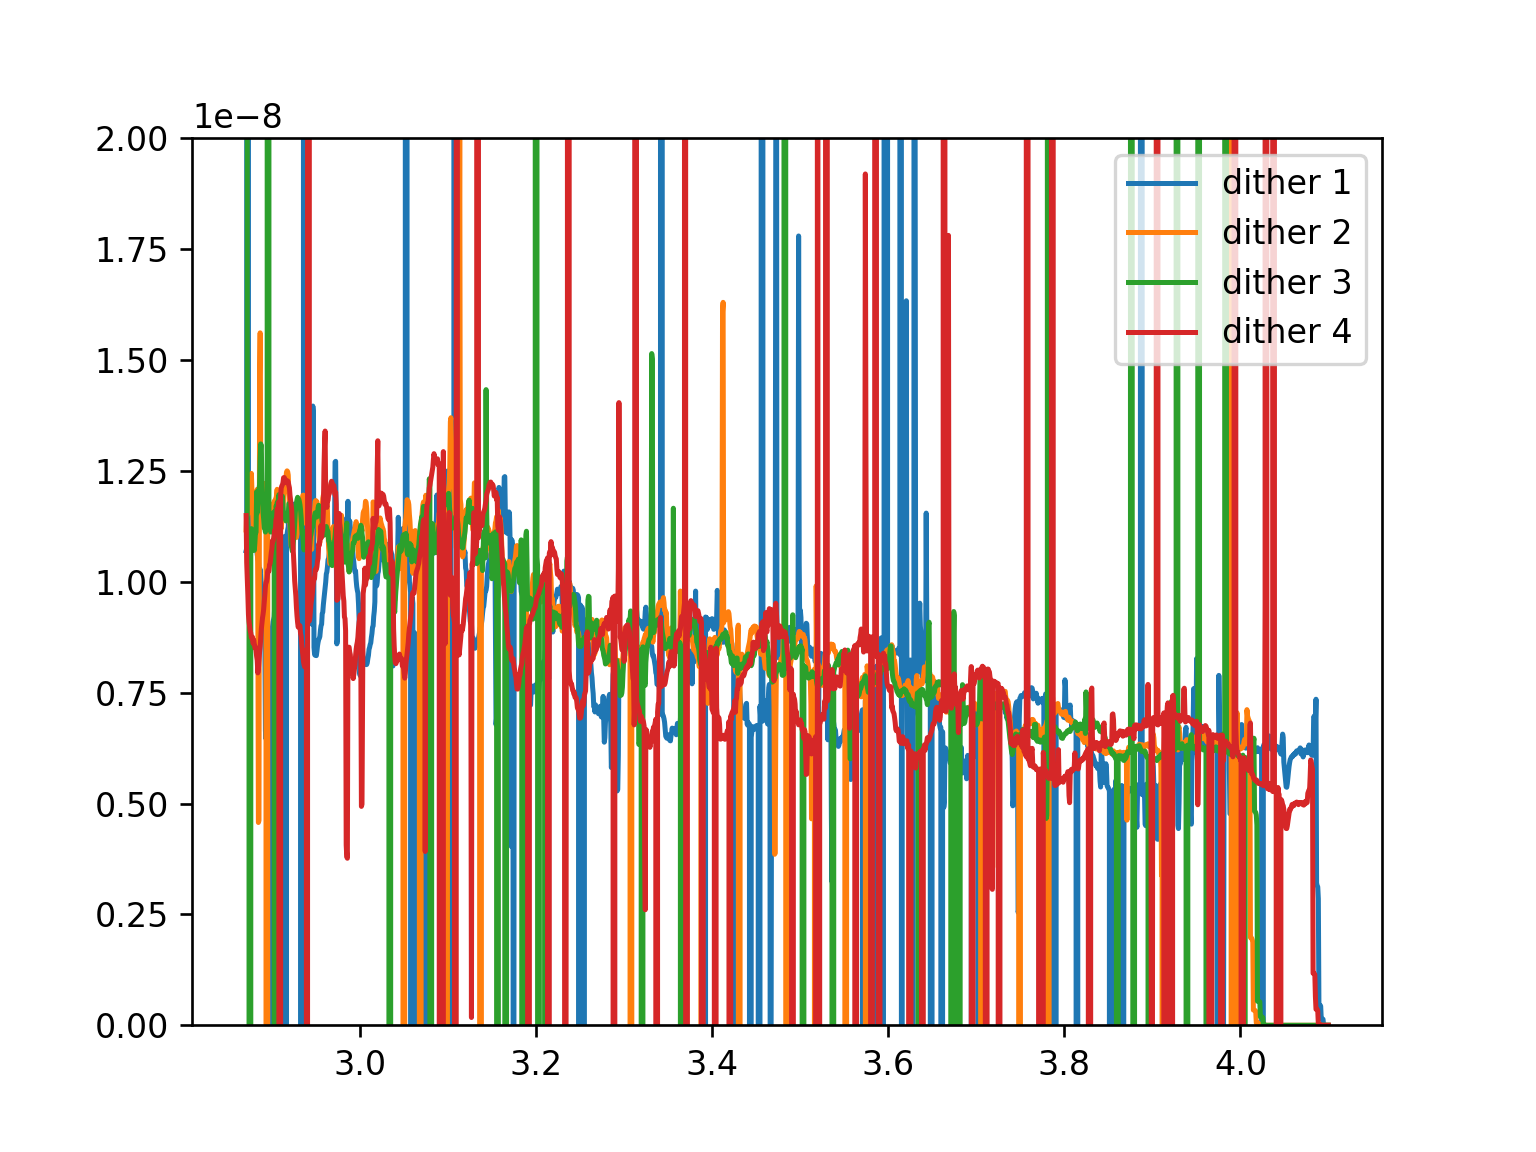

(0.0, 2e-08)

In [26]:
%matplotlib notebook
plt.plot(wavelength1, flux1, label = 'dither 1')
plt.plot(wavelength2, flux2, label = 'dither 2')
plt.plot(wavelength3, flux3, label = 'dither 3')
plt.plot(wavelength4, flux4, label = 'dither 4')
plt.legend()
plt.ylim([0,2e-8])


<IPython.core.display.Javascript object>


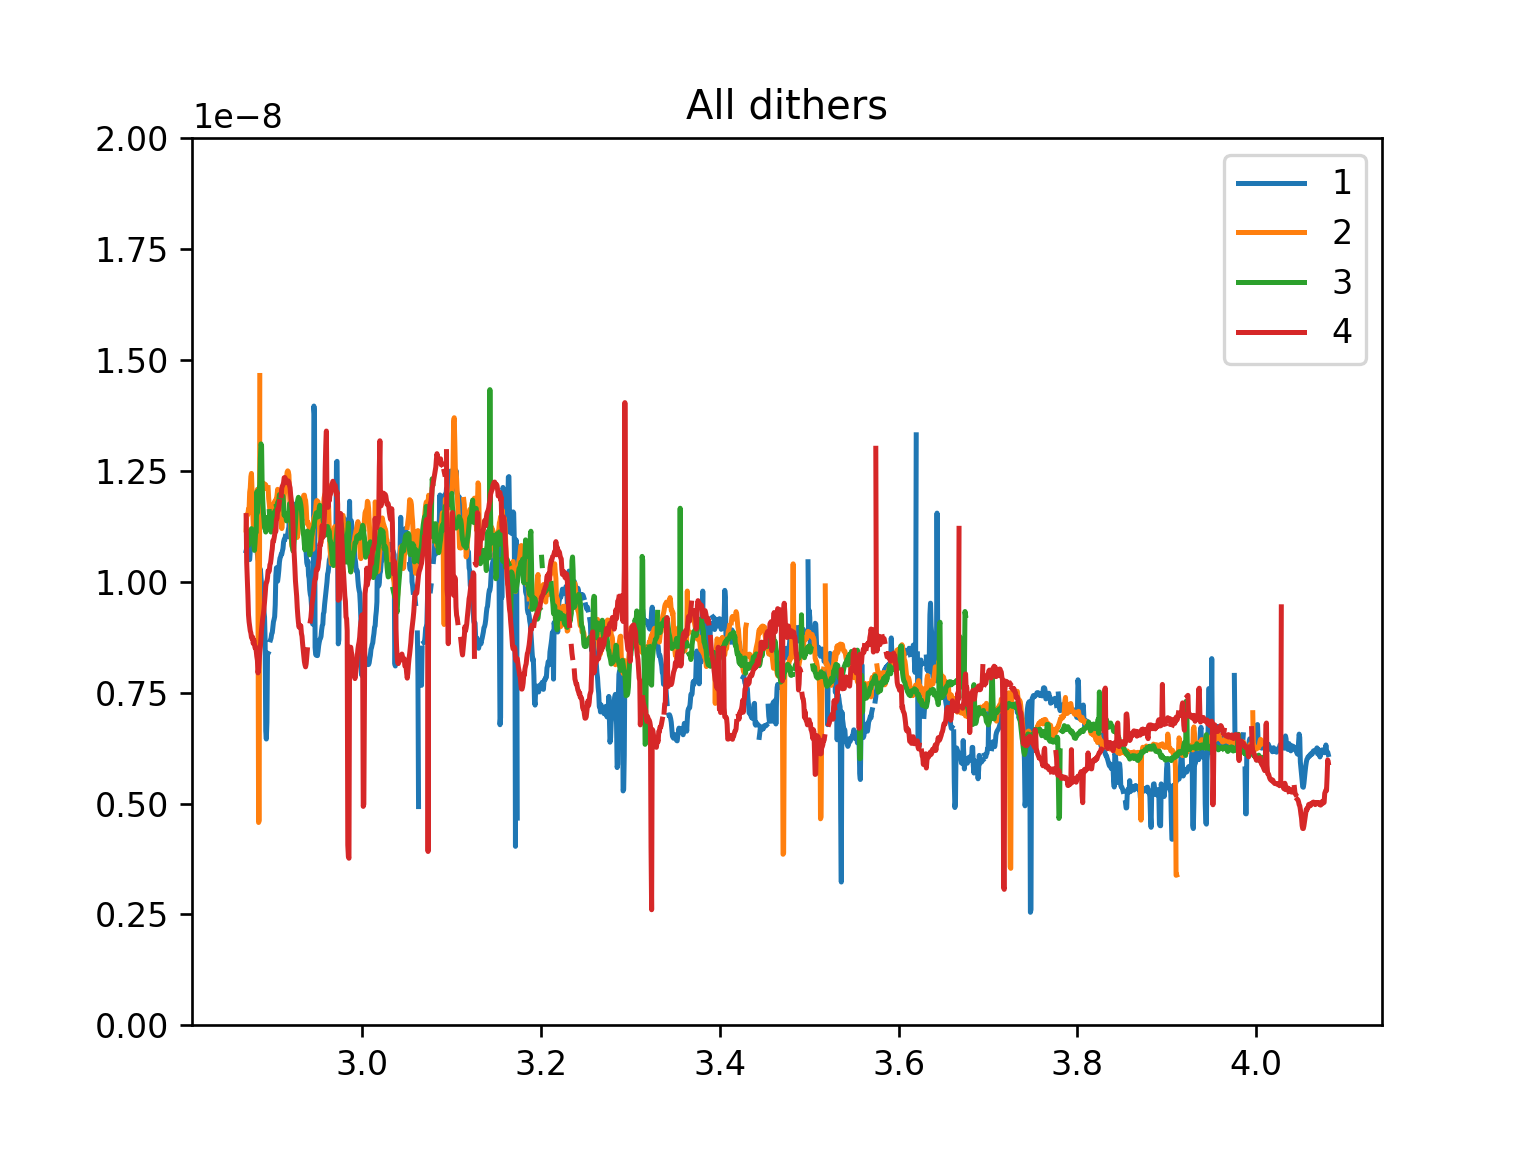

In [30]:
#clipping spectra

bad_edge = n.where(wavelength1 > 4.00730)
flux2[bad_edge] = n.nan
flux3[bad_edge] = n.nan

bad_edge2 = n.where(wavelength1 > 4.08057)
flux1[bad_edge2] = n.nan
flux4[bad_edge2] = n.nan

bad_edge3 = n.where(wavelength1 < 2.8624)
flux1[bad_edge3] = n.nan
flux2[bad_edge3] = n.nan
flux3[bad_edge3] = n.nan
flux4[bad_edge3] = n.nan


cutoff_high = 1.5e-8
cutoff_low = .25e-8
cosmic_ray1 = n.where( (flux1 > cutoff_high) | (flux1 < cutoff_low ) )
cosmic_ray2 = n.where( (flux2 > cutoff_high) | (flux2 < cutoff_low ) )
cosmic_ray3 = n.where( (flux3 > cutoff_high) | (flux3 < cutoff_low ) )
cosmic_ray4 = n.where( (flux4 > cutoff_high) | (flux4 < cutoff_low ) )

flux1[cosmic_ray1] = n.nan
flux2[cosmic_ray2] = n.nan
flux3[cosmic_ray3] = n.nan
flux4[cosmic_ray4] = n.nan


%matplotlib notebook
plt.title('All dithers')
plt.plot(wavelength1, flux1, label = '1')
plt.plot(wavelength2, flux2, label = '2')
plt.plot(wavelength3, flux3, label = '3')
plt.plot(wavelength4, flux4, label = '4')
plt.ylim([0,2e-8])
plt.legend()

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_47220/2143222180.py:10: RuntimeWarning: divide by zero encountered in divide
  weights = 1/(errors[:,i])**2


<IPython.core.display.Javascript object>


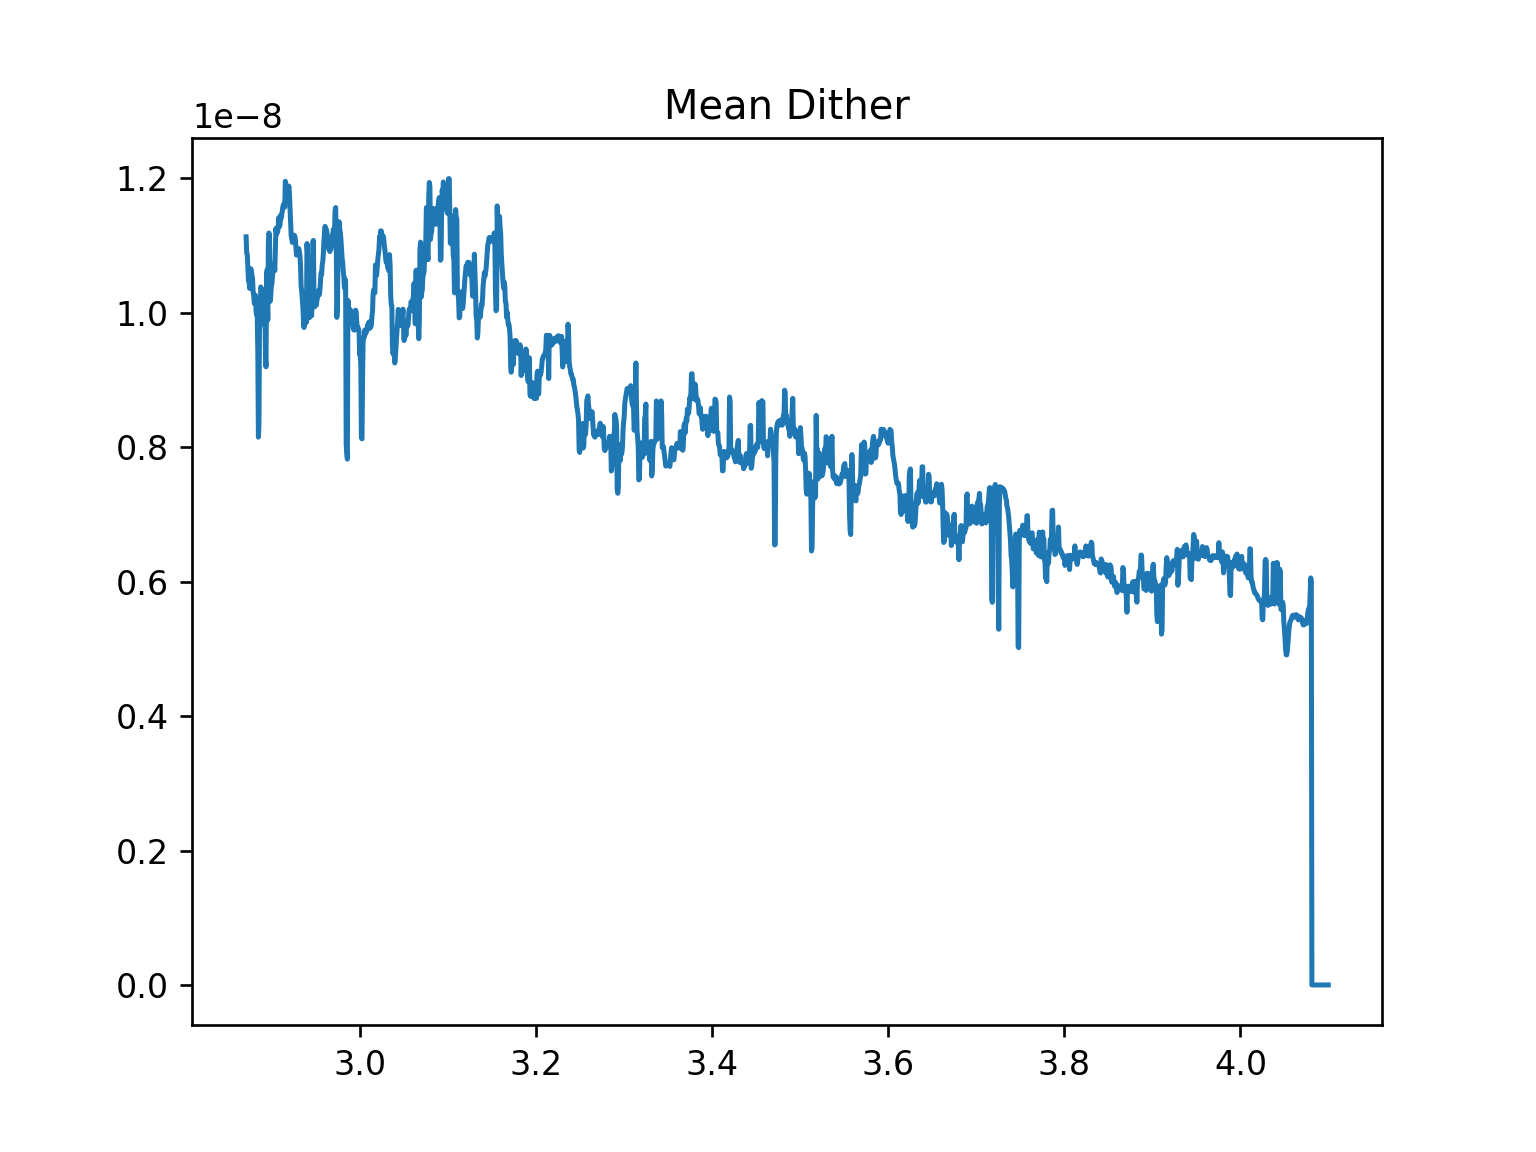

In [31]:
fluxes = n.vstack([flux1, flux2, flux3, flux4])
errors = n.vstack([error1, error2, error3, error4])

flux_mean = n.zeros(len(wavelength1))


for i in n.arange(0,len(wavelength1)):
    
    flux_values = fluxes[:,i]
    weights = 1/(errors[:,i])**2
    
    good = n.where(n.isnan(flux_values) == False)
    
    flux_values = flux_values[good]
    weights = weights[good]
    
    if len(flux_values) == 0:
        flux_mean[i] = 0
        
    else:
        flux_mean[i] = n.average(flux_values, weights= weights)

%matplotlib notebook
plt.title('Mean Dither')
plt.plot(wavelength1, flux_mean)
#plt.ylim([0,.7e-9])


In [32]:
#take a median but initally make a sigma clip within each wavelength element.
flux_update = n.zeros(len(flux_mean))
flux_error_update = n.zeros(len(flux_mean))
cutoff_high = 1.5e-8
cutoff_low = .25e-8

for i, wave in enumerate(wavelength1):

    flux_std = abs((fluxes[:,i] - n.nanmedian(fluxes[:,i]))/ n.nanstd(fluxes[:,i]))
    
    outlier = n.where(flux_std > 1)
    
    if len(outlier[0]) > 0:
 
    
        order = n.argsort(flux_std)
        flux_std = flux_std[order]

        flux_subset = fluxes[:,i][order]
        error_subset = errors[:,i][order]

        flux_subset_update = flux_subset[0:3]
        error_subset_update = error_subset[0:3]
        
        weights = 1/(error_subset_update)**2
        
        
        #make a n.nan clip and hard cut off 
        bad = n.where((flux_subset_update > cutoff_high) | (flux_subset_update < cutoff_low) )
        flux_subset_update[bad] = n.nan
        error_subset_update[bad] = n.nan

        good = n.where(n.isnan(flux_subset_update) == False)
        
        flux_subset_update = flux_subset_update[good]
        weights = weights[good]
        error_subset_update = error_subset_update[good]
        
        if len(good[0]) < 1:
            new_flux_mean = n.nan
            new_flux_mean_err = n.nan
            
        else:
            new_flux_mean = n.average(flux_subset_update, weights = weights) 
            new_flux_mean_err = n.sqrt(n.sum((weights * error_subset_update)**2) / (n.sum(weights)**2))
    #    
        flux_update[i] = new_flux_mean
        flux_error_update[i] = new_flux_mean_err
    else:
        
        flux_subset = fluxes[:,i]
        error_subset = errors[:,i]
        
        weights = 1/(error_subset)**2
        
        bad = n.where((flux_subset > cutoff_high) | (flux_subset < cutoff_low) )
        flux_subset[bad] = n.nan
        error_subset[bad] = n.nan
        
        good = n.where(n.isnan(flux_subset) == False)
        
        
        if len(good[0]) < 1:
            new_flux_mean = n.nan
            new_flux_mean_err = n.nan
            
        else:     
    
            flux_subset= flux_subset[good]
            weights = weights[good]
            error_subset = error_subset[good]
        
            new_flux_mean = n.average(flux_subset, weights = weights)
            new_flux_mean_err = n.sqrt(n.sum((weights * error_subset)**2) / (n.sum(weights)**2))
        
        flux_update[i] = new_flux_mean
        flux_error_update[i] = new_flux_mean_err

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_47220/2043292595.py:9: RuntimeWarning: invalid value encountered in divide
  flux_std = abs((fluxes[:,i] - n.nanmedian(fluxes[:,i]))/ n.nanstd(fluxes[:,i]))
/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_47220/2043292595.py:54: RuntimeWarning: divide by zero encountered in divide
  weights = 1/(error_subset)**2
/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_47220/2043292595.py:25: RuntimeWarning: divide by zero encountered in divide
  weights = 1/(error_subset_update)**2


<IPython.core.display.Javascript object>


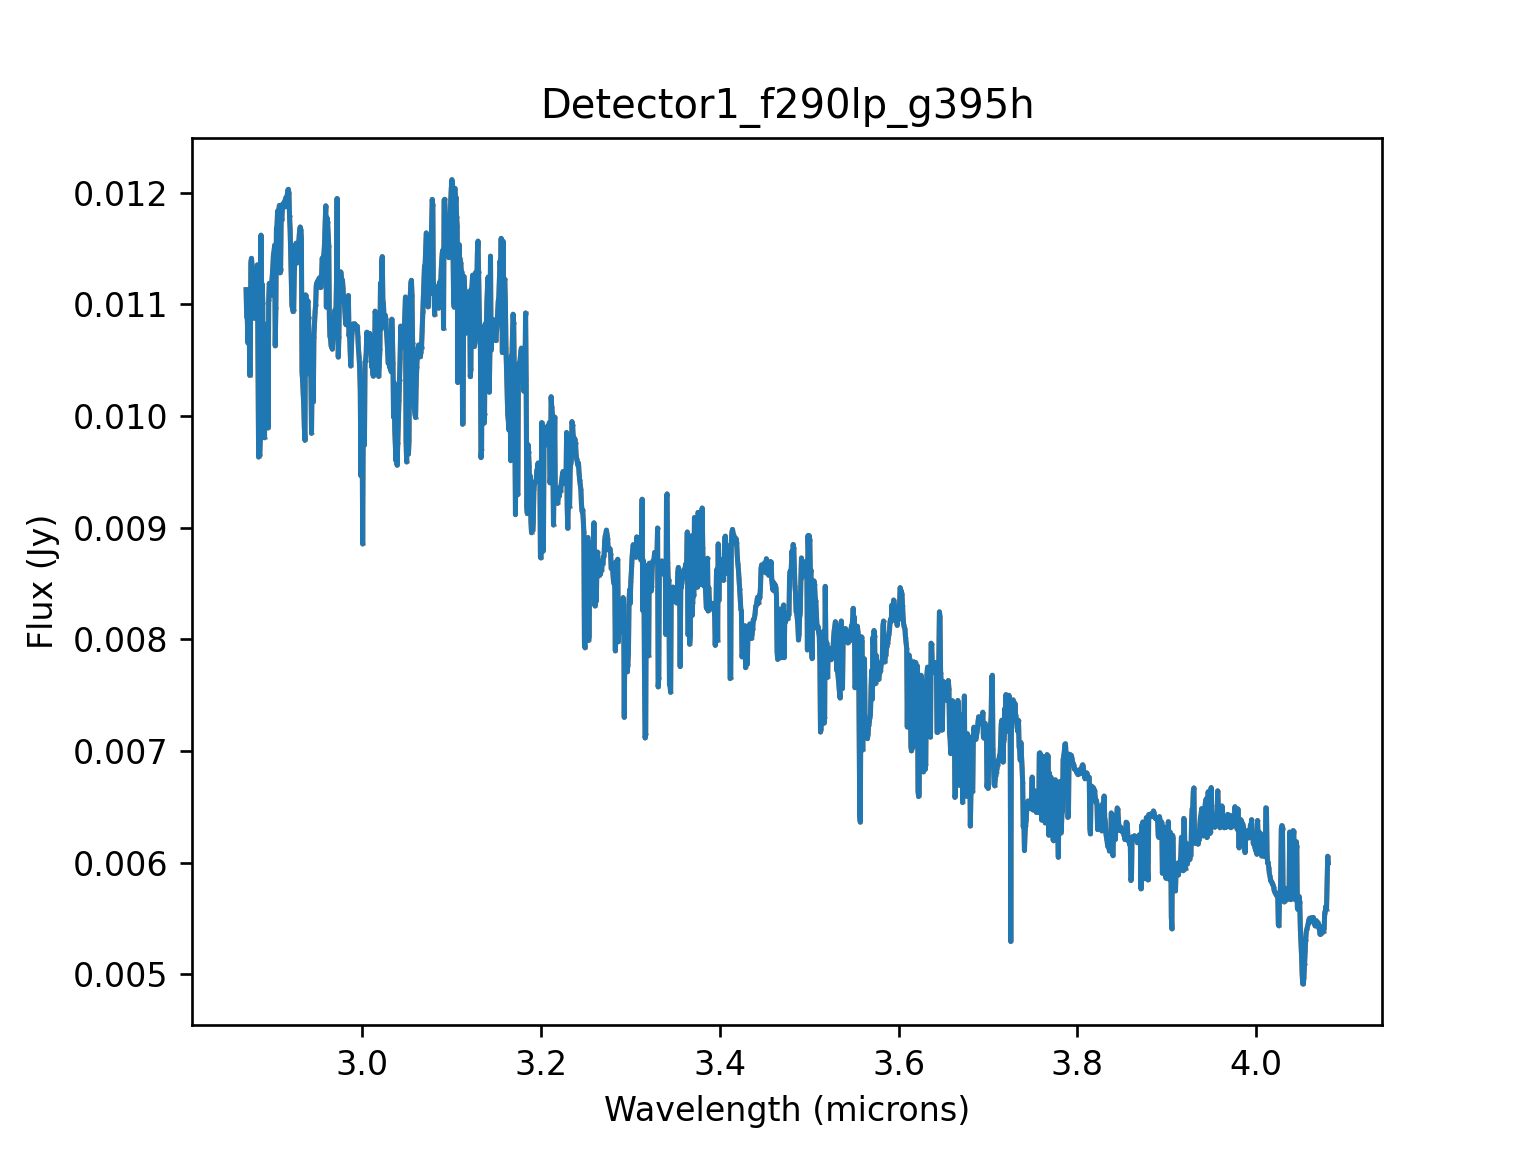

Text(0.5, 0, 'Wavelength (microns)')

In [33]:
%matplotlib notebook
plt.title('Detector1_f290lp_g395h')
plt.errorbar(wavelength1, flux_update * 1e6, yerr = flux_error_update * 1e6, linestyle = None, ecolor = '#a19fa1')
plt.plot(wavelength1, flux_update * 1e6)
plt.ylabel('Flux (Jy)')
plt.xlabel('Wavelength (microns)')

<IPython.core.display.Javascript object>


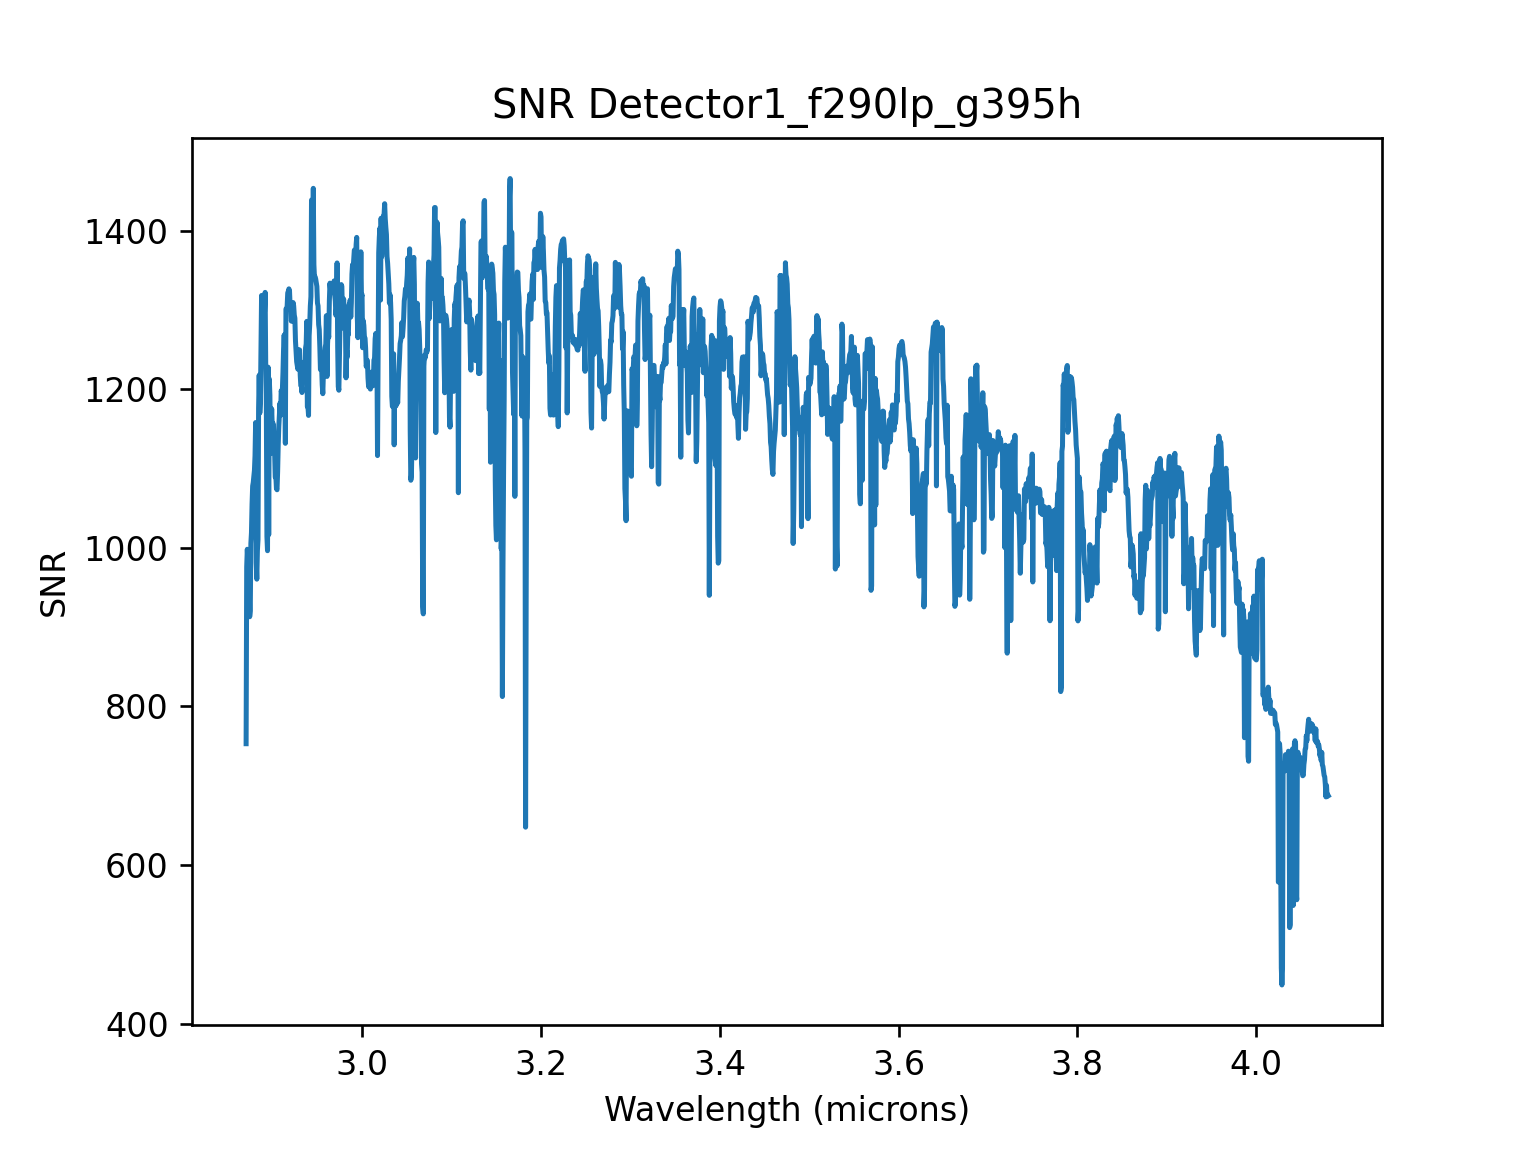

Text(0.5, 0, 'Wavelength (microns)')

In [35]:
%matplotlib notebook
plt.title('SNR Detector1_f290lp_g395h')
plt.plot(wavelength1, flux_update/flux_error_update)
#plt.ylim([-1,200])
plt.ylabel('SNR')
plt.xlabel('Wavelength (microns)')

In [37]:
#save text file of the spectrum
data_out = n.vstack((wavelength1,  flux_update * 1e6 , flux_error_update * 1e6))
data_out = n.transpose(data_out)

spectra_dir = 'spectra/' #if the directory does not exist create it
if not os.path.exists(spectra_dir):
    os.makedirs(spectra_dir)

header = 'wavelength (microns) flux(Jy), flux error(Jy)'
n.savetxt('spectra/detector1_f290lp_g395h.txt', data_out, header = header)